In [200]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analysis Chico

## Import the data

In [204]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
from pathlib import Path
from utils.analysis import *
from utils.chico_analysis import *


subs_of_interest = ['AmItheAsshole', 'confessions', 'tifu']

def import_subreddit(subreddit):
    location_name = Path().cwd() / 'datasets' / f'{subreddit}.csv'
    return pd.read_csv(location_name)

subreddit_df = pd.concat([import_subreddit(subreddit) for subreddit in subs_of_interest], ignore_index=True)

def open_json_sub(subreddit_name):
    path_to_sub = Path().cwd() / 'data' / f'{subreddit_name}.json'
    with open(path_to_sub, 'r') as f:
        subreddit_dict = json.load(f)
    return subreddit_dict

subreddit_dict = {subreddit: open_json_sub(subreddit) for subreddit in subs_of_interest}


In [154]:
results = {}

for sub in subs_of_interest:    
    # posts = scraper.get_subreddit_posts(sub, limit=100, cache=True)
    # posts_df = create_posts_dataframe(subreddit_dict)
    
    tfidf_results = tfidf_df(subreddit_df[subreddit_df['subreddit'] == sub], include_selftext=True)
    # tfidf_results = tfidf_analyze_subreddit(posts)
    tf_idf_scores = get_mean_tfidf(
        tfidf_matrix=tfidf_results['tfidf_matrix'],
        feature_names=tfidf_results['feature_names'],
        return_df=True
    )
    results[sub] = {"posts_df":subreddit_df[subreddit_df['subreddit'] == sub],
                    "tfidf_results":tfidf_results,
                    "tf_idf_scores":tf_idf_scores}



In [155]:
# Extract the vocabulary for each subreddit
vocabularies = {sub: set(results[sub]['tfidf_results']['feature_names']) for sub in subs_of_interest}

# Get the intersection of the vocabularies
common_vocab = set.intersection(*vocabularies.values())

# Report analytics
print(f"Number of common terms across all subreddits: {len(common_vocab)}")
print(f"Common terms: {', '.join(list(common_vocab)[:10])}...")  # Display first 10 common terms

# Calculate Jaccard similarity for each pair of subreddits
for sub1 in subs_of_interest:
    for sub2 in subs_of_interest:
        if sub1 > sub2:
            intersection = vocabularies[sub1].intersection(vocabularies[sub2])
            union = vocabularies[sub1].union(vocabularies[sub2])
            jaccard_similarity = len(intersection) / len(union)
            print(f"Jaccard similarity between {sub1} and {sub2}: {jaccard_similarity:.3f}")

# Report unique terms for each subreddit
for sub in subs_of_interest:
    unique_terms = vocabularies[sub] - common_vocab
    print(f"Number of unique terms in {sub}: {len(unique_terms)}")
    print(f"Unique terms in {sub}: {', '.join(list(unique_terms)[:10])}...")  # Display first 10 unique terms

Number of common terms across all subreddits: 633
Common terms: anyway, might, shower, experience, pay, possible, different, due, possibly, proceed...
Jaccard similarity between confessions and AmItheAsshole: 0.548
Jaccard similarity between tifu and AmItheAsshole: 0.589
Jaccard similarity between tifu and confessions: 0.567
Number of unique terms in AmItheAsshole: 367
Unique terms in AmItheAsshole: spending, grandparent, household, intention, express, lily, fiancé, mentally, shes, shot...
Number of unique terms in confessions: 367
Unique terms in confessions: protect, express, fear, poor, manipulate, moan, mentally, ocd, shes, addict...
Number of unique terms in tifu: 367
Unique terms in tifu: assignment, poor, paint, nowhere, teeth, delete, coworker, asshole, four, cream...


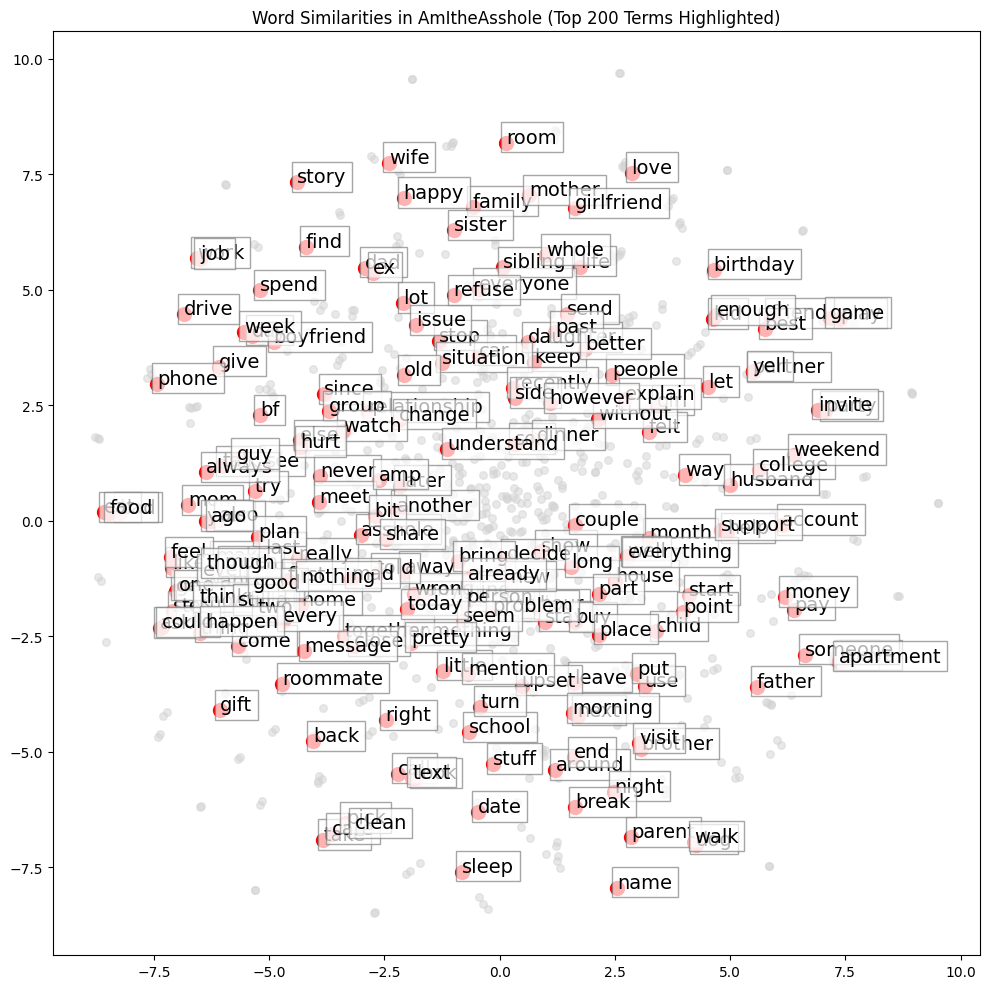

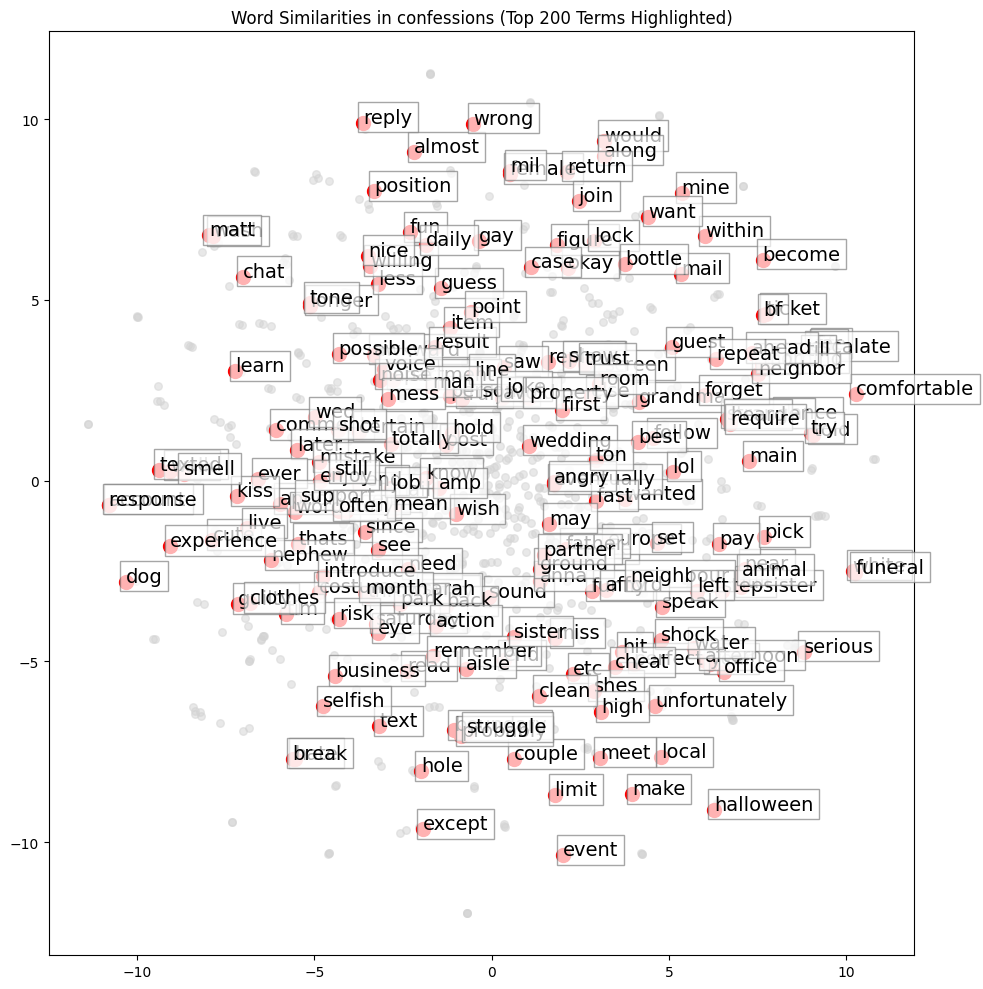

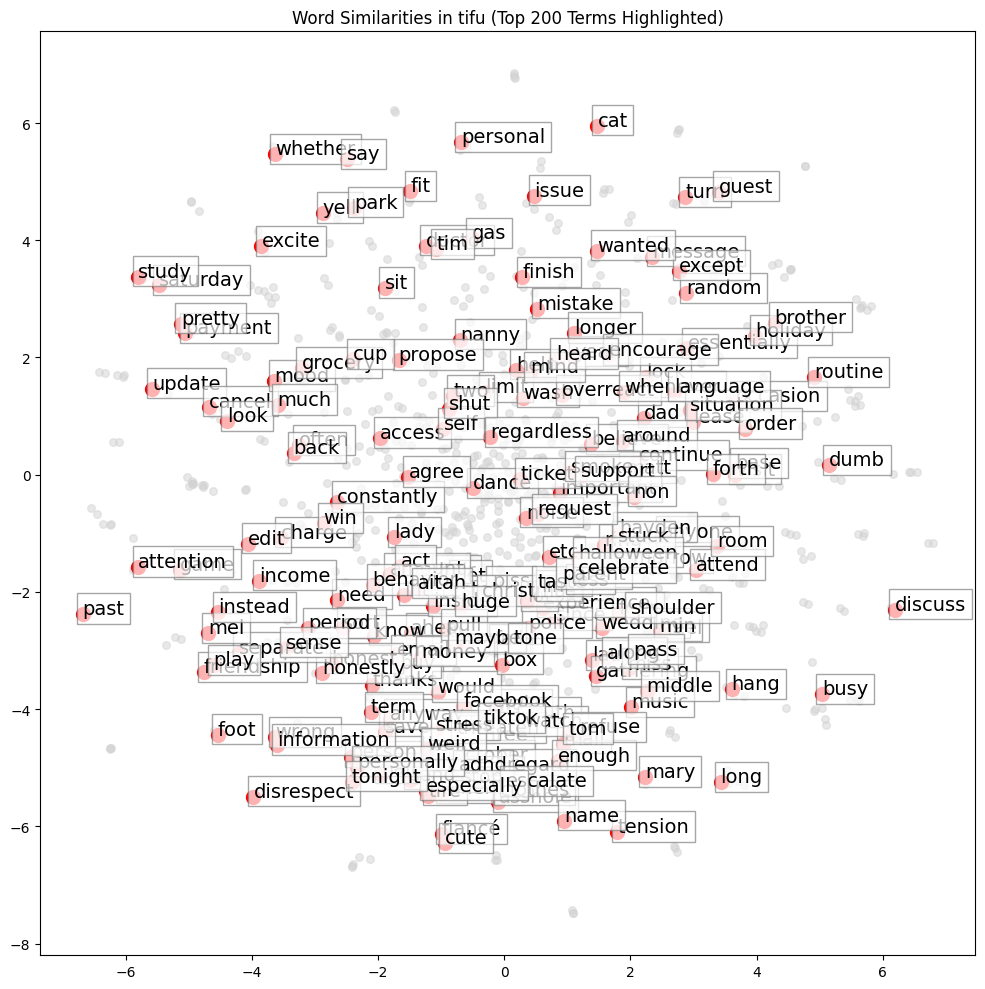

In [105]:
for sub in subs_of_interest:
    fig, ax = plot_word_similarities_tsne(results[sub]['tfidf_results']['tfidf_matrix'], 
                                results['AmItheAsshole']['tfidf_results']['feature_names'],
                                n_highlight=200, # Try changing this value
                                title=sub)
    plt.show()

### Visualizing the differences between words using t-SNE methods

### Gendered terms

There is a significant difference internally on the confessions regarding boyfriends and girlfriends. While boyfriends tend to be associated with more violent imagery, girlfriends are associated with ____.

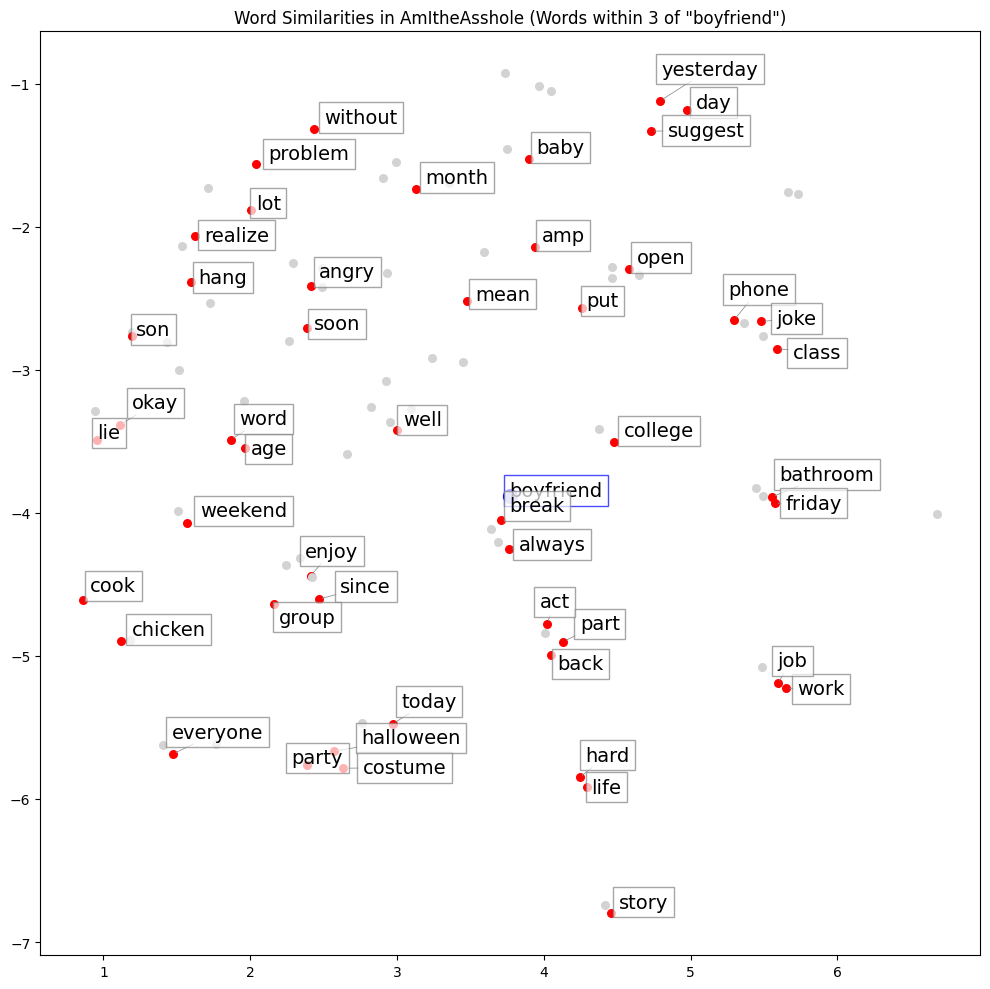

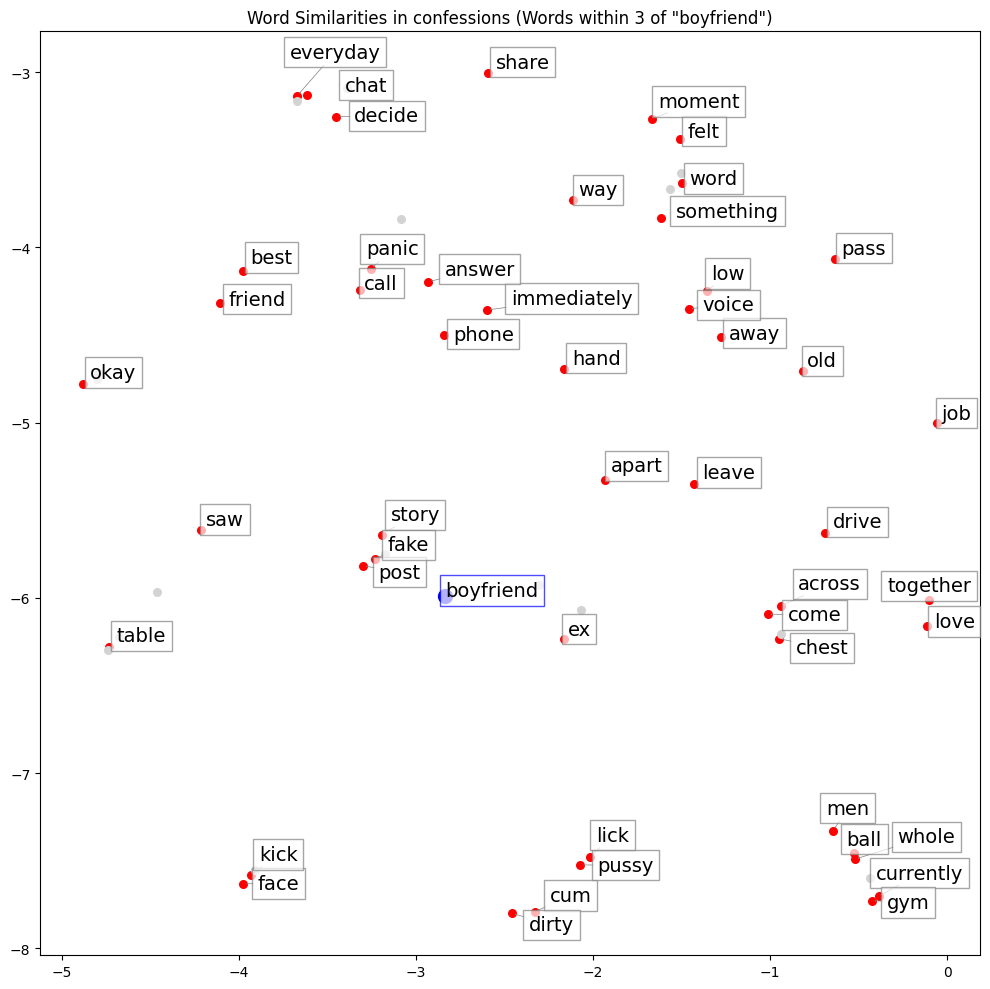

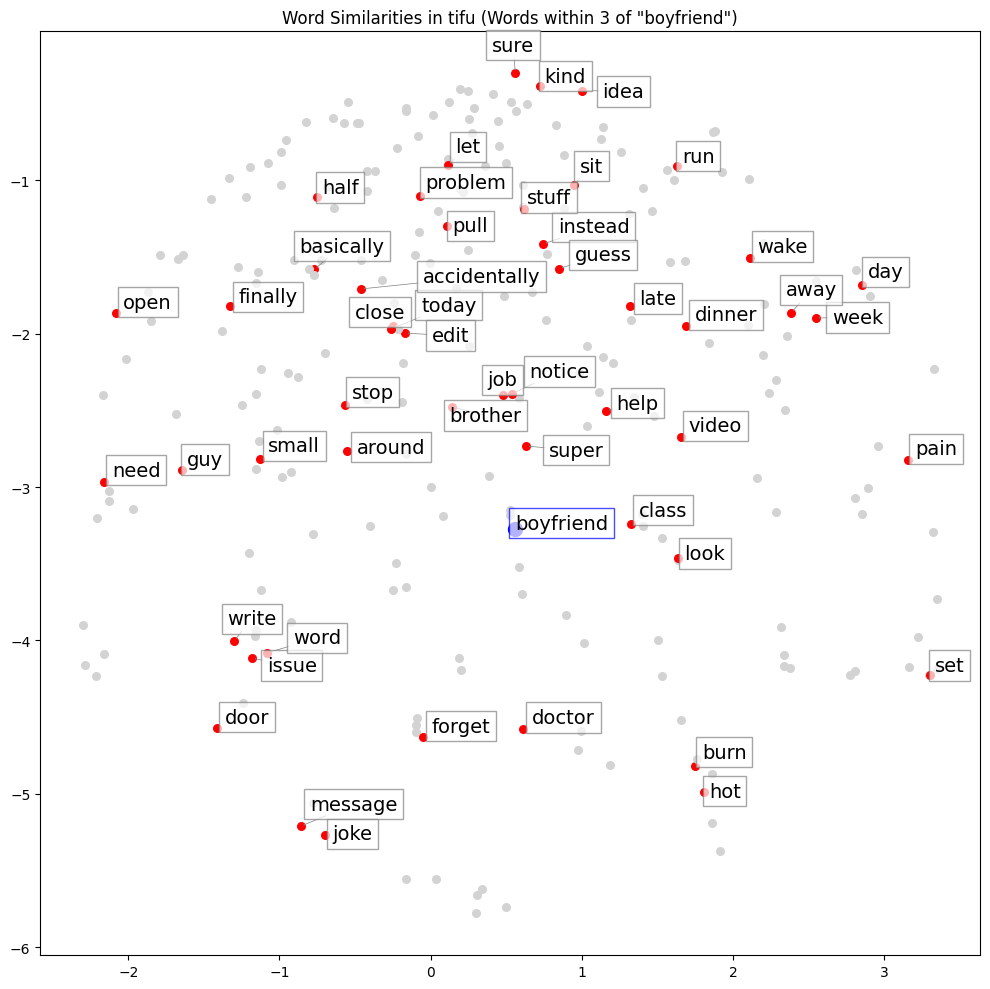

In [193]:
def get_word_graphs(resuts, word, distance=3, highlight=50):
    for sub in subs_of_interest:
        fig, ax = plot_word_distance(results[sub]['tfidf_results']['tfidf_matrix'], 
                                        results[sub]['tfidf_results']['feature_names'],
                                        word = word,
                                        distance = distance,
                                        n_highlight=highlight, # Try changing this value
                                        title=sub)
        plt.show() 

get_word_graphs(results, 'boyfriend', distance=3, highlight=50)

We can try the same with wife and husband, to see how these play out

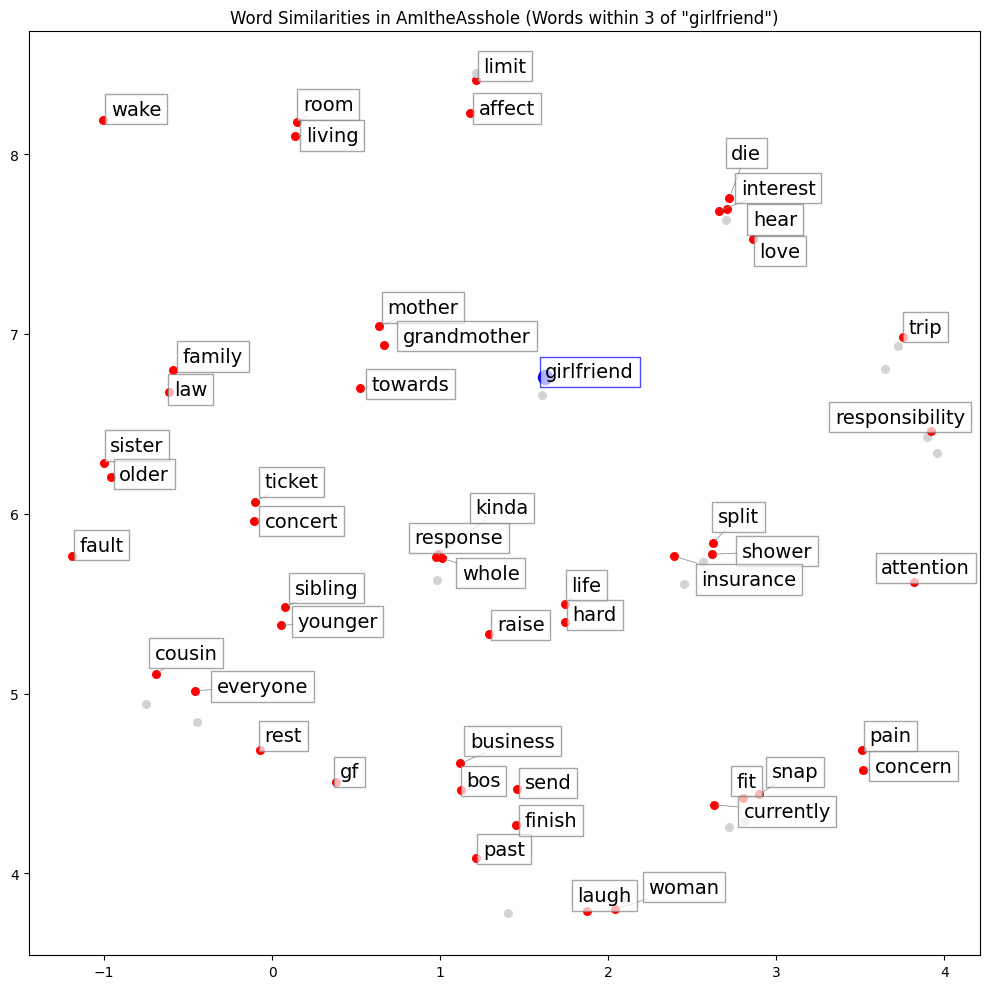

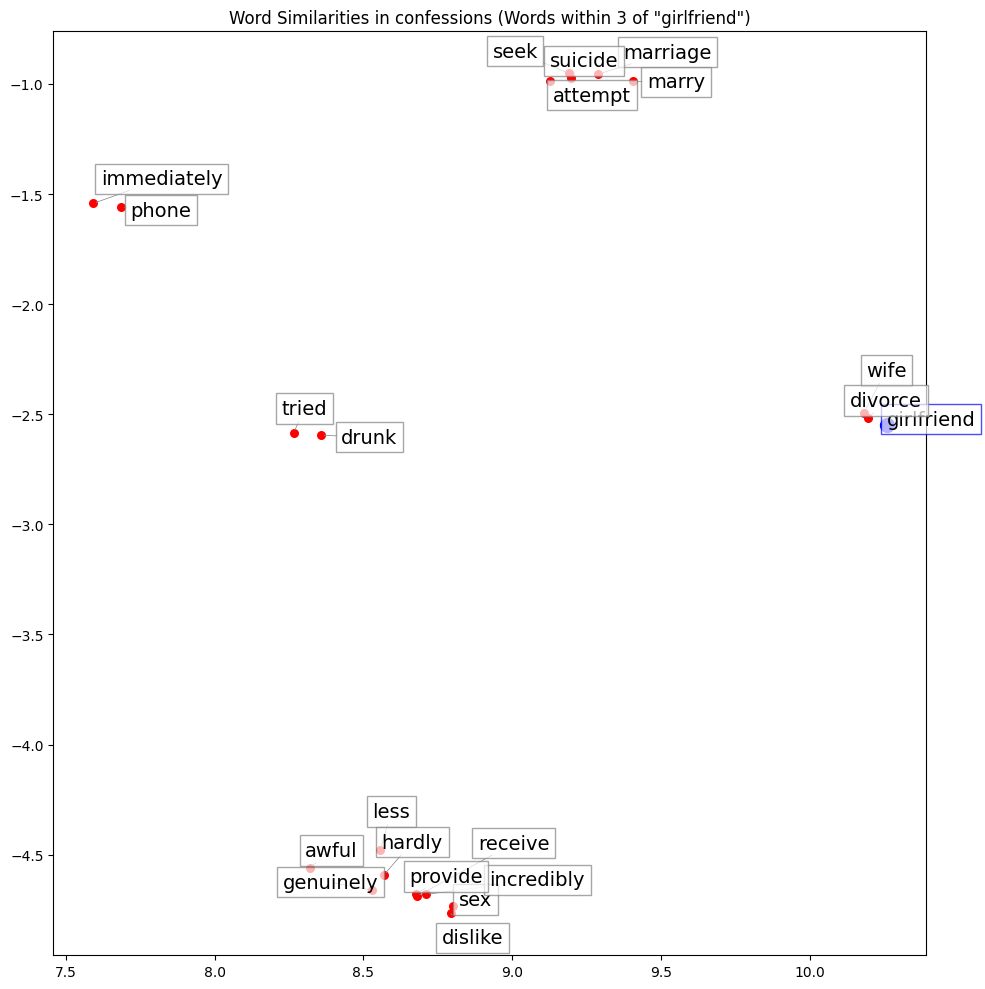

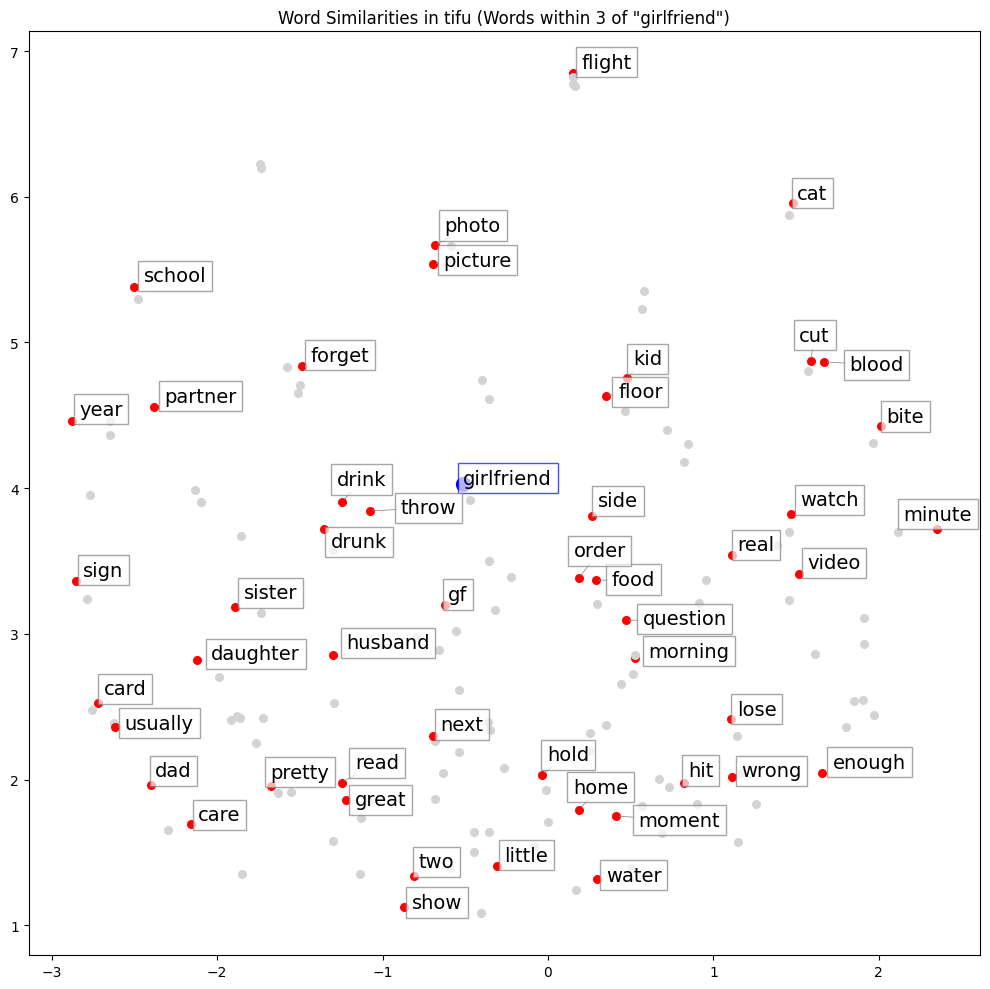

In [97]:
get_word_graphs(results, 'girlfriend')

Wife is mostly related to the role of children, quite close to ideas of study.

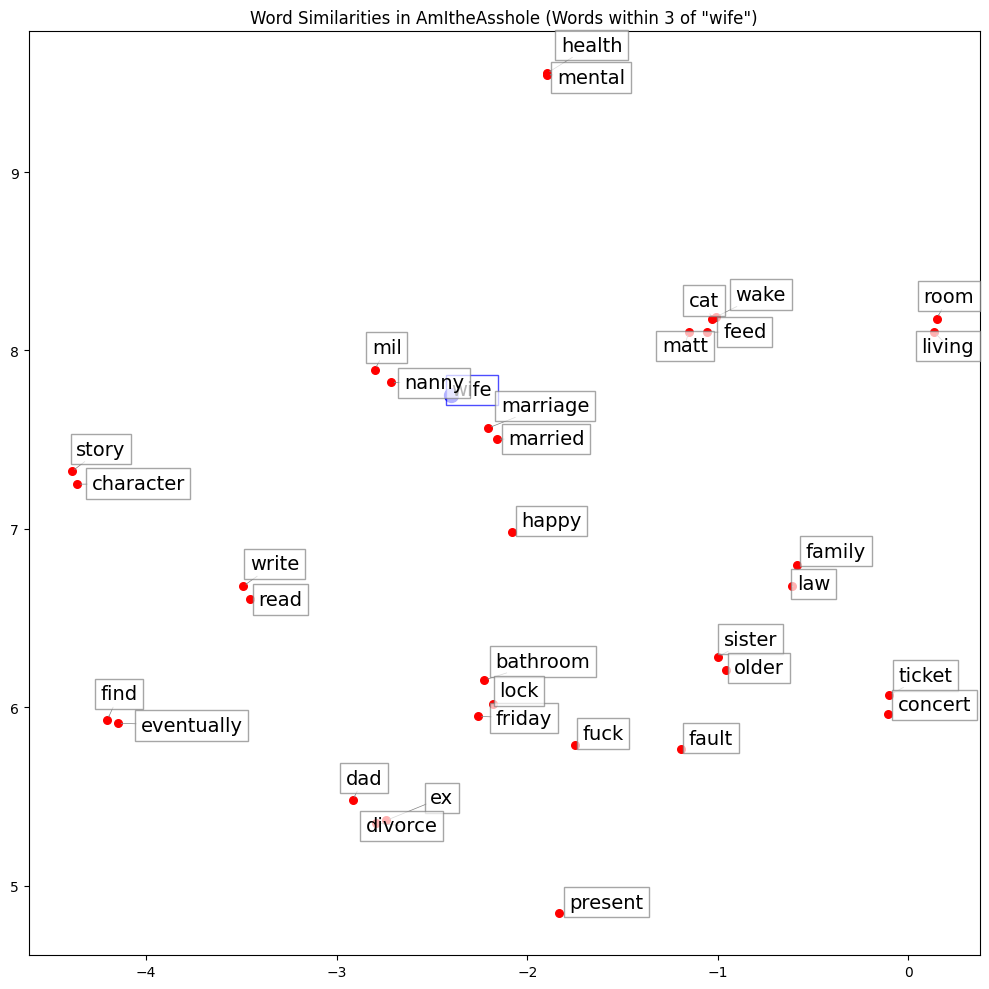

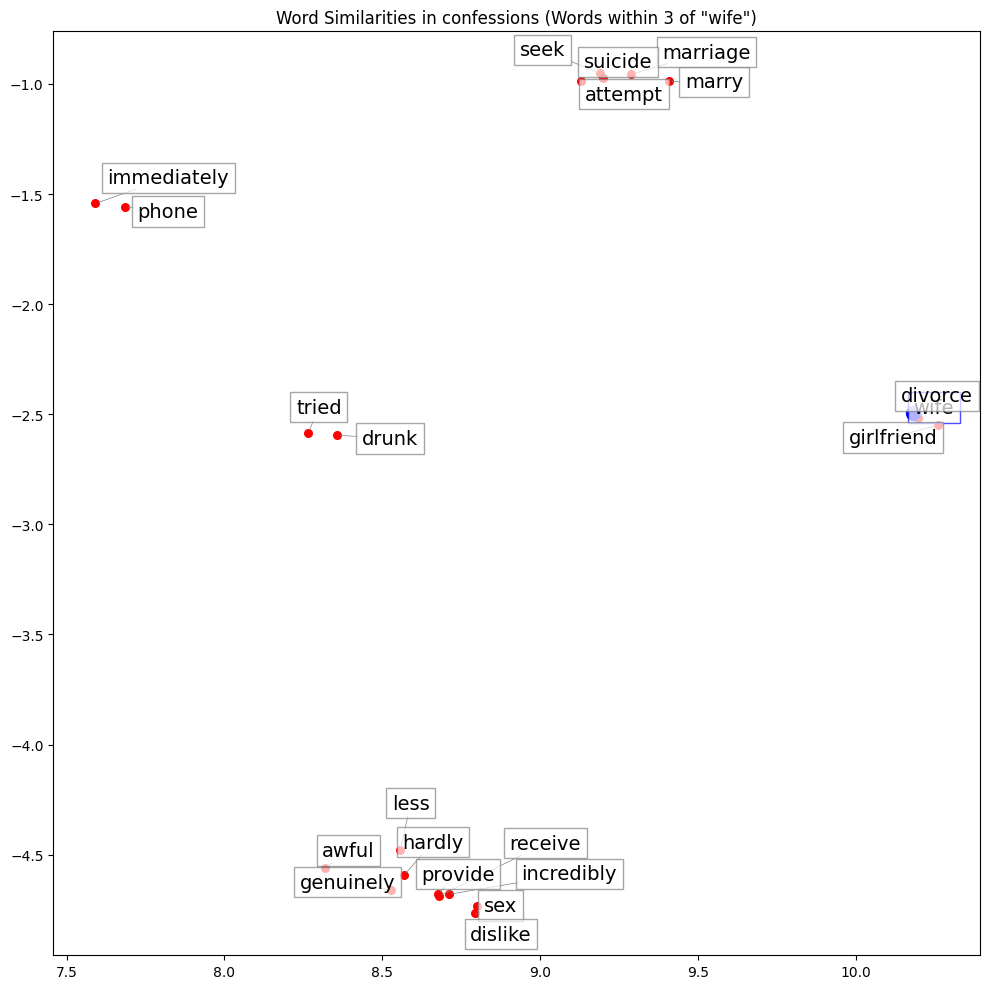

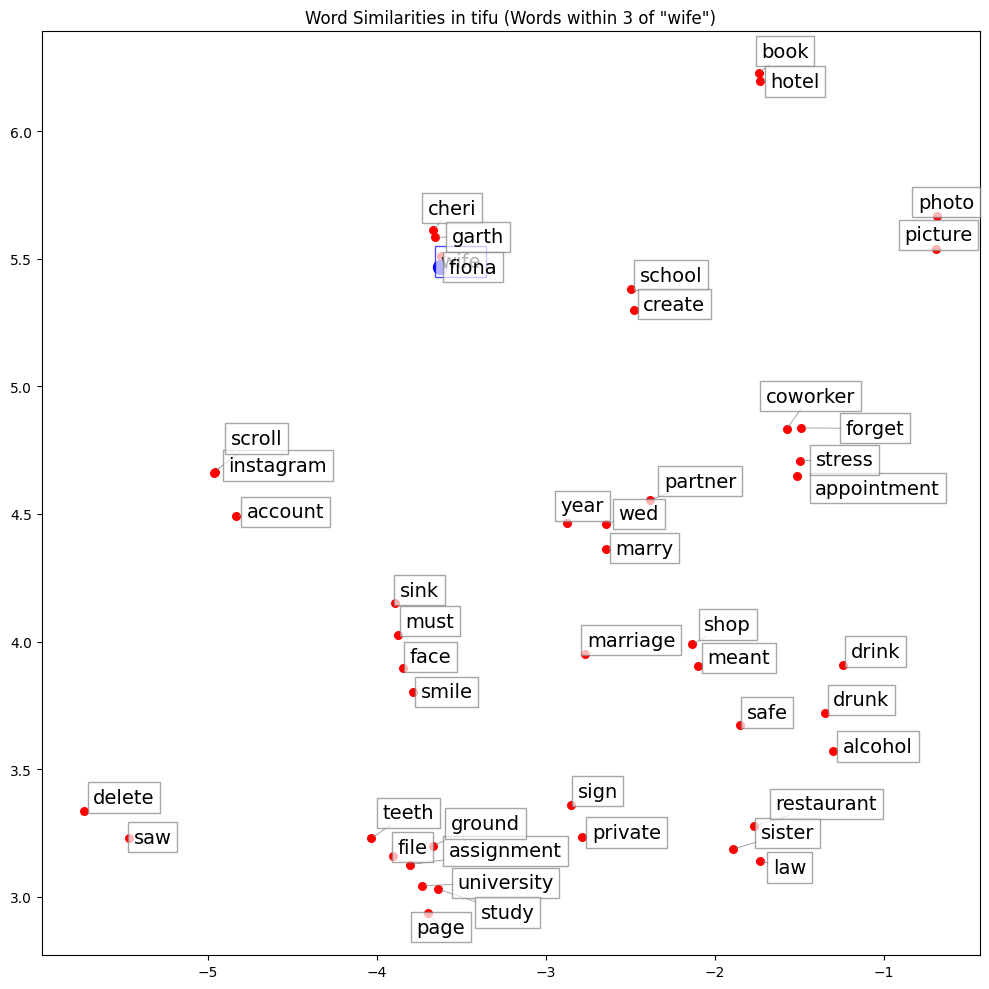

In [98]:
get_word_graphs(results, 'wife', distance=3, highlight=50)

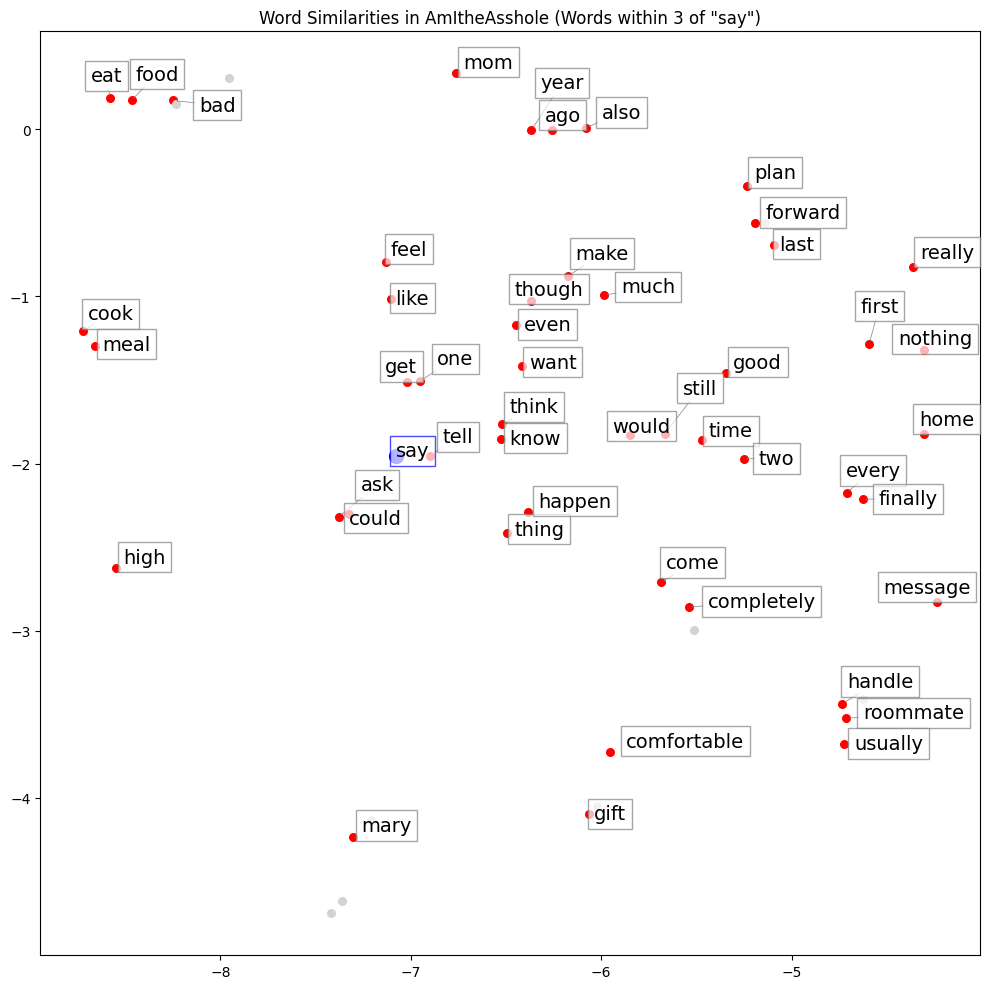

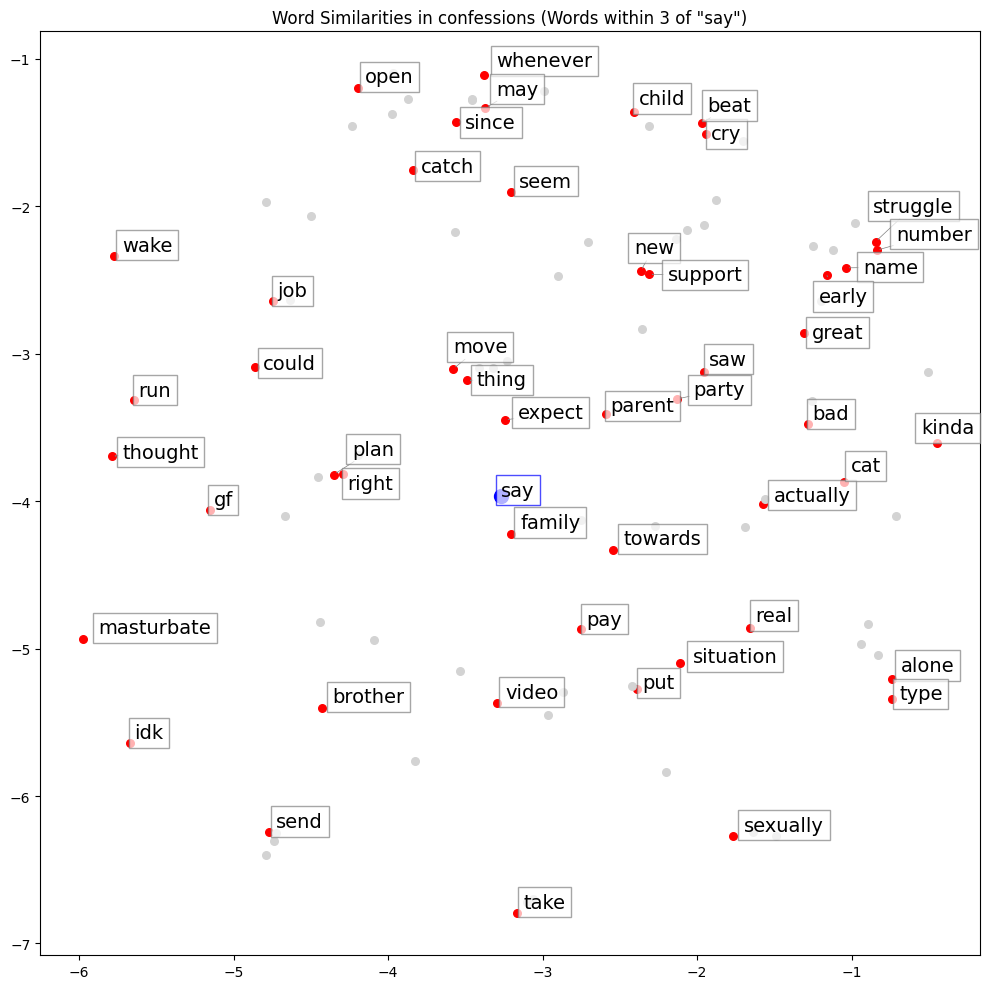

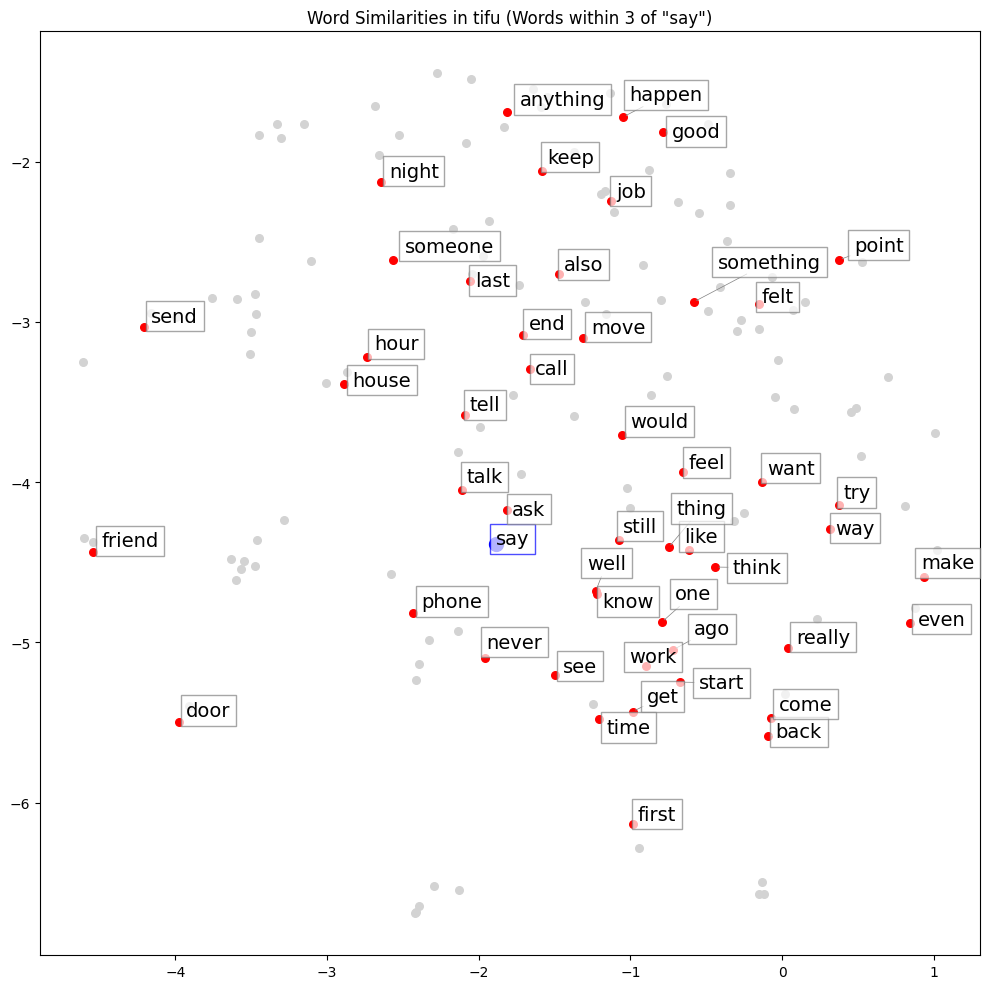

In [145]:
get_word_graphs(results, 'say', distance=3, highlight=50)

# Calculating cosines for words

In [156]:
def get_word_similar(word, distance=3):
    cosines = {
        sub: cosine_dist_word_net(
            results[sub]['tfidf_results']['tfidf_matrix'], 
            results[sub]['tfidf_results']['feature_names'],
            word=word,
            distance=distance
        )
        for sub in subs_of_interest
    }

    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity

    # Step 1: Extract unique terms (vocabulary) across all subreddits
    vocabulary = set(word for terms in cosines.values() for word, _ in terms)
    vocabulary = sorted(vocabulary)  # Sort for consistent ordering
    word_index = {word: idx for idx, word in enumerate(vocabulary)}

    # Step 2: Create TF-IDF vectors for each subreddit based on the vocabulary
    def create_tfidf_vector(term_list, word_index):
        vector = np.zeros(len(word_index))
        for word, score in term_list:
            if word in word_index:
                vector[word_index[word]] = score
        return vector

    subreddit_vectors = {sub: create_tfidf_vector(terms, word_index) for sub, terms in cosines.items()}
    all_relation = []
    # Step 3: Calculate cosine similarity between subreddits
    for sub1 in subreddit_vectors:
        for sub2 in subreddit_vectors:
            if sub1 > sub2:
                cosine_comp = cosine_similarity([subreddit_vectors[sub1]], [subreddit_vectors[sub2]])[0, 0]
                print(f"Cosine similarity between {sub1} and {sub2}: {cosine_comp:.3f}")
                all_relation.append((sub1, sub2, cosine_comp))
    if all_relation:
        return all_relation
    else:
        return None

                



In [157]:
# Step 1: Find common words across all subreddits
all_words = [set(results[sub]['tfidf_results']['feature_names']) for sub in subs_of_interest]
common_words = set.intersection(*all_words)

relationship_terms = [
    # Partner-related terms
    'wife', 'husband', 'spouse', 'partner', 'girlfriend', 'boyfriend', 'fiancee', 'fiance',
    'gf', 'bf', 'significant other', 'so', 'ex', 'ex-girlfriend', 'ex-boyfriend', 'ex-wife',
    
    # Family-related terms
    'mom', 'dad', 'mother', 'father', 'sister', 'brother', 'aunt', 'uncle', 'cousin',
    'niece', 'nephew', 'grandmother', 'grandfather', 'grandma', 'grandpa', 'daughter', 
    'son', 'child', 'children', 'kid', 'kids', 'parent', 'parents', 'family', 'fam',
    
    # Friend-related terms
    'friend', 'friends', 'buddy', 'buddies', 'pal', 'pals', 'mate', 'mates', 
    'companion', 'companions', 'acquaintance', 'acquaintances', 'chum', 'chums', 
    'confidant', 'confidants', 'ally', 'allies', 'associate', 'associates', 
    'roommate', 'roommates', 'colleague', 'colleagues', 'coworker', 'coworkers', 
    'teammate', 'teammates', 'classmate', 'neighbor'
]
check_word = common_words.intersection(relationship_terms)

# # Step 2: Calculate average TF-IDF for each common word
# word_avg_tfidf = {}

# for word in common_words:
#     tfidf_scores = []
#     for sub in subs_of_interest:
#         feature_names = results[sub]['tfidf_results']['feature_names']
        
#         # Convert feature_names to a list if it is a numpy array
#         if isinstance(feature_names, np.ndarray):
#             feature_names = feature_names.tolist()
        
#         # Get the index of the word in each subreddit's feature names
#         word_index = feature_names.index(word)
        
#         # Get the TF-IDF score for the word in this subreddit
#         tfidf_score = results[sub]['tfidf_results']['tfidf_matrix'][:, word_index].mean()
#         tfidf_scores.append(tfidf_score)
    
#     # Calculate the average TF-IDF score across subreddits
#     word_avg_tfidf[word] = np.mean(tfidf_scores)

# # Step 3: Sort words by average TF-IDF score and select the top 50
# top_25_words = sorted(word_avg_tfidf.items(), key=lambda x: x[1], reverse=True)[:25]
# top_25_words = [word for word, avg_score in top_25_words]

print(len(check_word))


word_distance = {
    word: get_word_similar(word, distance=2)
    for word in check_word
}


17
Cosine similarity between confessions and AmItheAsshole: 0.173
Cosine similarity between tifu and AmItheAsshole: 0.162
Cosine similarity between tifu and confessions: 0.103
Cosine similarity between confessions and AmItheAsshole: 0.128
Cosine similarity between tifu and AmItheAsshole: 0.151
Cosine similarity between tifu and confessions: 0.149
Cosine similarity between confessions and AmItheAsshole: 0.162
Cosine similarity between tifu and AmItheAsshole: 0.104
Cosine similarity between tifu and confessions: 0.031
Cosine similarity between confessions and AmItheAsshole: 0.057
Cosine similarity between tifu and AmItheAsshole: 0.235
Cosine similarity between tifu and confessions: 0.197
Cosine similarity between confessions and AmItheAsshole: 0.179
Cosine similarity between tifu and AmItheAsshole: 0.170
Cosine similarity between tifu and confessions: 0.166
Cosine similarity between confessions and AmItheAsshole: 0.153
Cosine similarity between tifu and AmItheAsshole: 0.116
Cosine simila

In [158]:
word_distance

{'girlfriend': [('confessions',
   'AmItheAsshole',
   np.float64(0.1729609674642423)),
  ('tifu', 'AmItheAsshole', np.float64(0.1621335213641818)),
  ('tifu', 'confessions', np.float64(0.10262622161273213))],
 'wife': [('confessions', 'AmItheAsshole', np.float64(0.12849990002385744)),
  ('tifu', 'AmItheAsshole', np.float64(0.15080245968602007)),
  ('tifu', 'confessions', np.float64(0.14909340983814495))],
 'boyfriend': [('confessions',
   'AmItheAsshole',
   np.float64(0.16211348601993703)),
  ('tifu', 'AmItheAsshole', np.float64(0.10446055007504768)),
  ('tifu', 'confessions', np.float64(0.03067355931274106))],
 'sister': [('confessions', 'AmItheAsshole', np.float64(0.05669709336938679)),
  ('tifu', 'AmItheAsshole', np.float64(0.23527298236135613)),
  ('tifu', 'confessions', np.float64(0.19730296836107702))],
 'child': [('confessions', 'AmItheAsshole', np.float64(0.17874142791878456)),
  ('tifu', 'AmItheAsshole', np.float64(0.1696483600216398)),
  ('tifu', 'confessions', np.float64(0

## Calculating the cocine difference of neighbor words in the three sets

In [159]:

# Flatten the dictionary into a list of rows
rows = []
for word, relationships in word_distance.items():
    for subreddit_1, subreddit_2, cosine_distance in relationships:
        rows.append({
            'word': word,
            'subreddit_1': subreddit_1,
            'subreddit_2': subreddit_2,
            'cosine_distance': cosine_distance
        })

# Convert the list of rows into a DataFrame
df = pd.DataFrame(rows)

df['subreddit_pair'] = df[['subreddit_1', 'subreddit_2']].apply(lambda x: ' - '.join(sorted(x)), axis=1)
# Display the DataFrame
display(df)

word  subreddit_1    subreddit_2  cosine_distance  \
0   girlfriend  confessions  AmItheAsshole         0.172961   
1   girlfriend         tifu  AmItheAsshole         0.162134   
2   girlfriend         tifu    confessions         0.102626   
3         wife  confessions  AmItheAsshole         0.128500   
4         wife         tifu  AmItheAsshole         0.150802   
5         wife         tifu    confessions         0.149093   
6    boyfriend  confessions  AmItheAsshole         0.162113   
7    boyfriend         tifu  AmItheAsshole         0.104461   
8    boyfriend         tifu    confessions         0.030674   
9       sister  confessions  AmItheAsshole         0.056697   
10      sister         tifu  AmItheAsshole         0.235273   
11      sister         tifu    confessions         0.197303   
12       child  confessions  AmItheAsshole         0.178741   
13       child         tifu  AmItheAsshole         0.169648   
14       child         tifu    confessions         0.166222   
15      mother  confessions  AmItheAsshole         0.153060   
16      mother         tifu  AmItheAsshole         0.116210   
17      mother         tifu    confessions         0.168376   
18     husband  confessions  AmItheAsshole         0.034549   
19     husband         tifu  AmItheAsshole         0.034978   
20     husband         tifu    confessions         0.011605   
21      family  confessions  AmItheAsshole         0.113308   
22      family         tifu  AmItheAsshole         0.118133   
23      family         tifu    confessions         0.058155   
24     partner  confessions  AmItheAsshole         0.066452   
25     partner         tifu  AmItheAsshole         0.087444   
26     partner         tifu    confessions         0.024509   
27         son  confessions  AmItheAsshole         0.053362   
28         son         tifu  AmItheAsshole         0.092965   
29         son         tifu    confessions         0.013448   
30    daughter  confessions  AmItheAsshole         0.012939   
31    daughter         tifu  AmItheAsshole         0.304009   
32    daughter         tifu    confessions         0.072311   
33          ex  confessions  AmItheAsshole         0.093280   
34          ex         tifu  AmItheAsshole         0.022883   
35          ex         tifu    confessions         0.094716   
36      father  confessions  AmItheAsshole         0.233222   
37      father         tifu  AmItheAsshole         0.166550   
38      father         tifu    confessions         0.126499   
39      parent  confessions  AmItheAsshole         0.050192   
40      parent         tifu  AmItheAsshole         0.226842   
41      parent         tifu    confessions         0.042224   
42      cousin  confessions  AmItheAsshole         0.040657   
43      cousin         tifu  AmItheAsshole         0.074846   
44      cousin         tifu    confessions         0.089420   
45      friend  confessions  AmItheAsshole         0.205320   
46      friend         tifu  AmItheAsshole         0.679818   
47      friend         tifu    confessions         0.184915   
48     brother  confessions  AmItheAsshole         0.096698   
49     brother         tifu  AmItheAsshole         0.094397   
50     brother         tifu    confessions         0.034137   

                 subreddit_pair  
0   AmItheAsshole - confessions  
1          AmItheAsshole - tifu  
2            confessions - tifu  
3   AmItheAsshole - confessions  
4          AmItheAsshole - tifu  
5            confessions - tifu  
6   AmItheAsshole - confessions  
7          AmItheAsshole - tifu  
8            confessions - tifu  
9   AmItheAsshole - confessions  
10         AmItheAsshole - tifu  
11           confessions - tifu  
12  AmItheAsshole - confessions  
13         AmItheAsshole - tifu  
14           confessions - tifu  
15  AmItheAsshole - confessions  
16         AmItheAsshole - tifu  
17           confessions - tifu  
18  AmItheAsshole - confessions  
19         AmItheAsshole - tifu  
20           confes

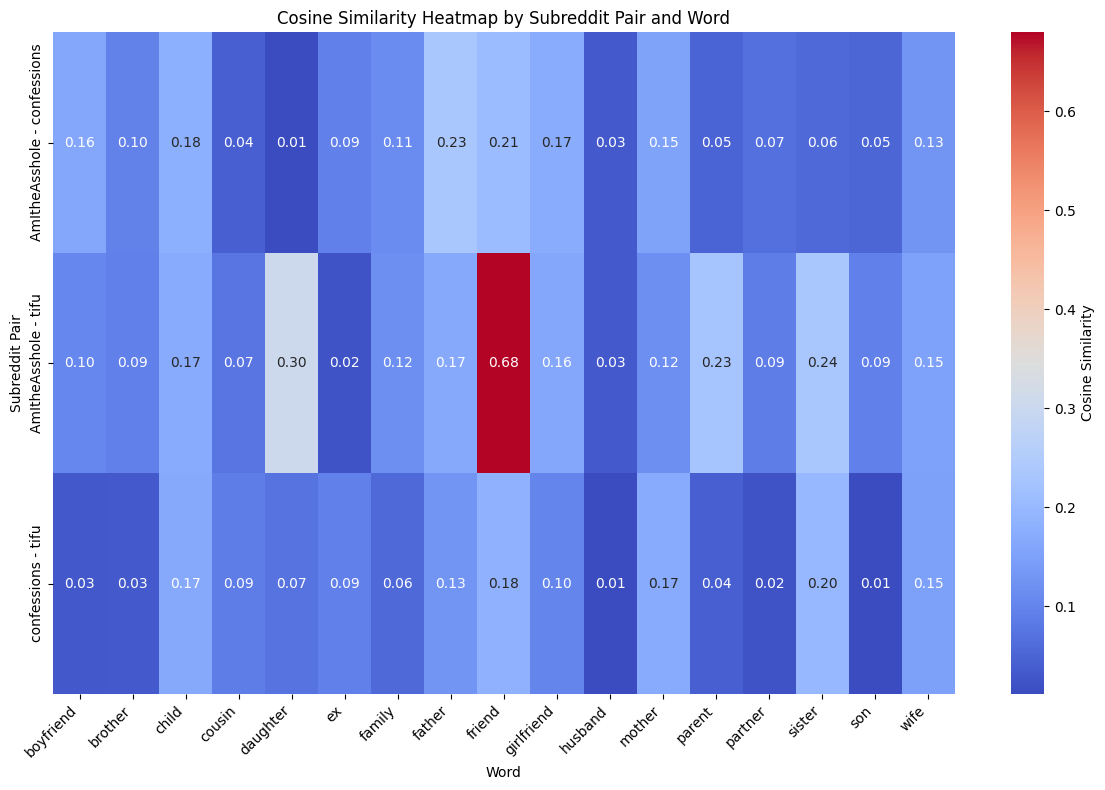

In [164]:
import seaborn as sns
# Pivot the DataFrame to create a matrix format suitable for a heatmap
heatmap_data = df.pivot(index='subreddit_pair', columns='word', values='cosine_distance')

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Cosine Similarity'})
plt.title("Cosine Similarity Heatmap by Subreddit Pair and Word")
plt.xlabel("Word")
plt.ylabel("Subreddit Pair")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in AmItheAsshole (Words within 3 of "friend")'}>)

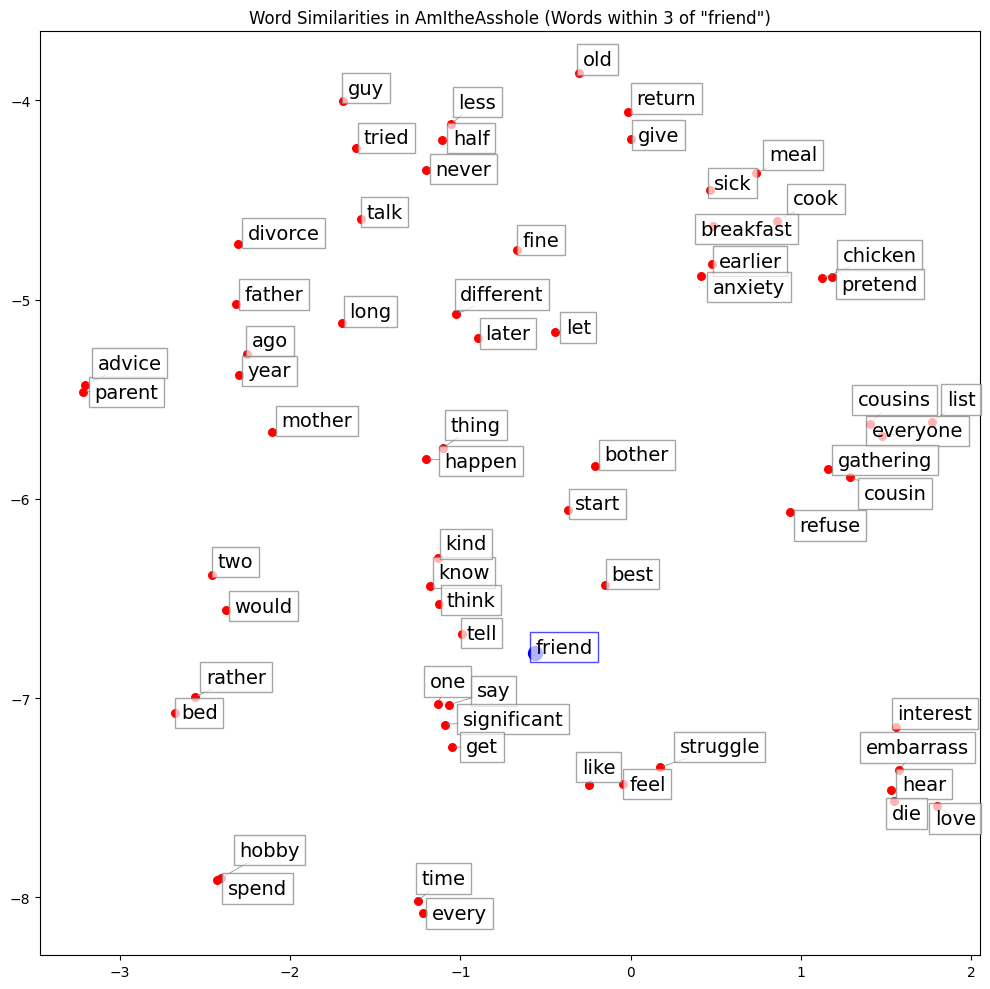

In [170]:
plot_word_distance(results['AmItheAsshole']['tfidf_results']['tfidf_matrix'], results['AmItheAsshole']['tfidf_results']['feature_names'], word='friend', distance=3, n_highlight=100, title='AmItheAsshole')

Check the difference in age and gender for subreddits

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in AmItheAsshole (Words within 3 of "friend")'}>)

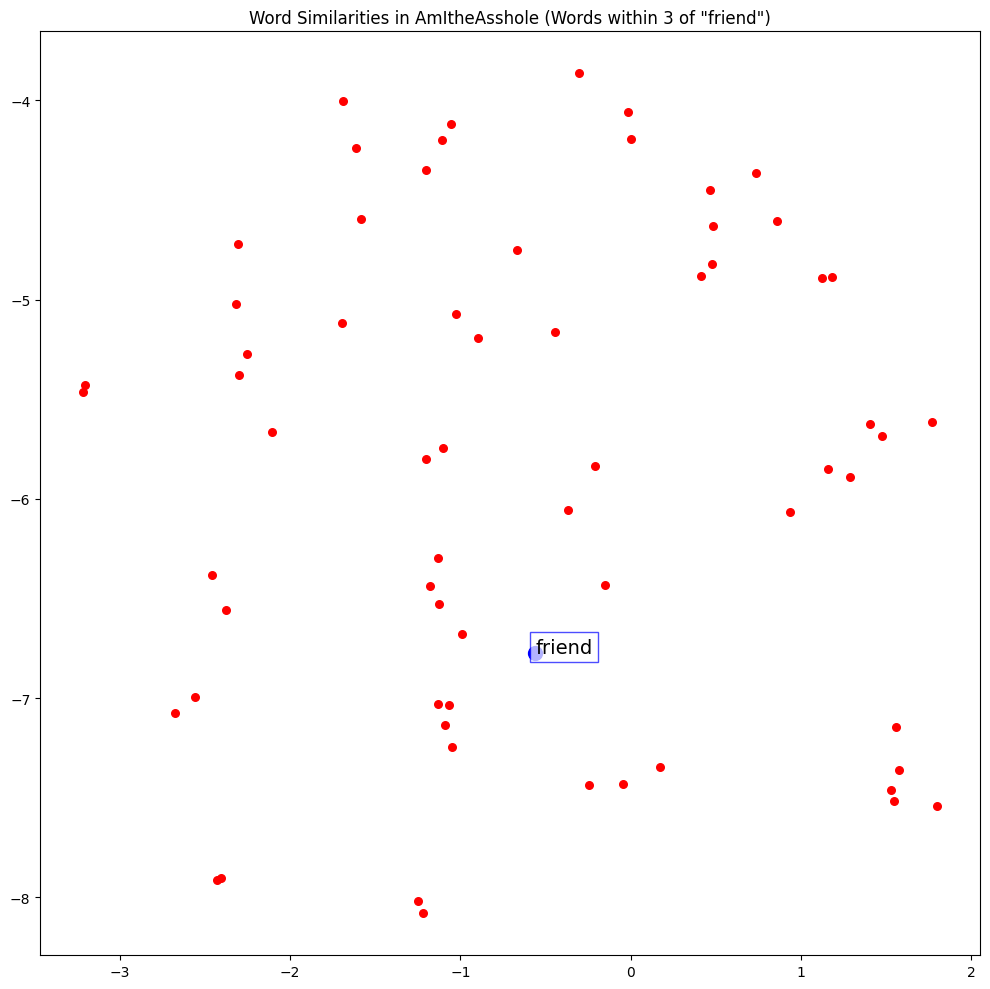

In [176]:
word_distance_reveal(results['AmItheAsshole']['tfidf_results']['tfidf_matrix'], 
                                        results['AmItheAsshole']['tfidf_results']['feature_names'], 'friend', distance=3,  xlim = (-51, -50), ylim=(-51, -50),
                                        title = "AmItheAsshole")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in AmItheAsshole (Words within 3 of "friend")'}>)

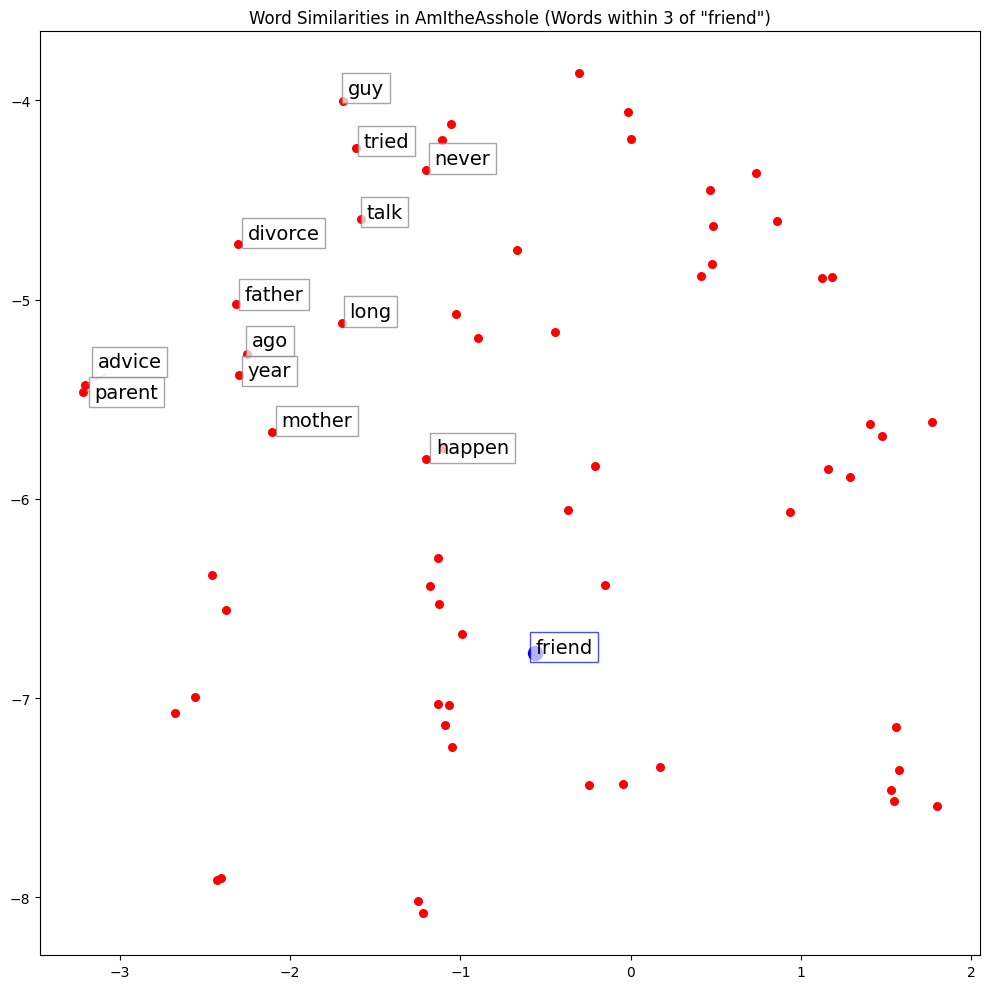

In [171]:
word_distance_reveal(results['AmItheAsshole']['tfidf_results']['tfidf_matrix'], 
                                        results['AmItheAsshole']['tfidf_results']['feature_names'], 'friend', distance=3,  xlim = (-4, -1.2), ylim=(-6, 0),
                                        title = "AmItheAsshole")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in AmItheAsshole (Words within 3 of "friend")'}>)

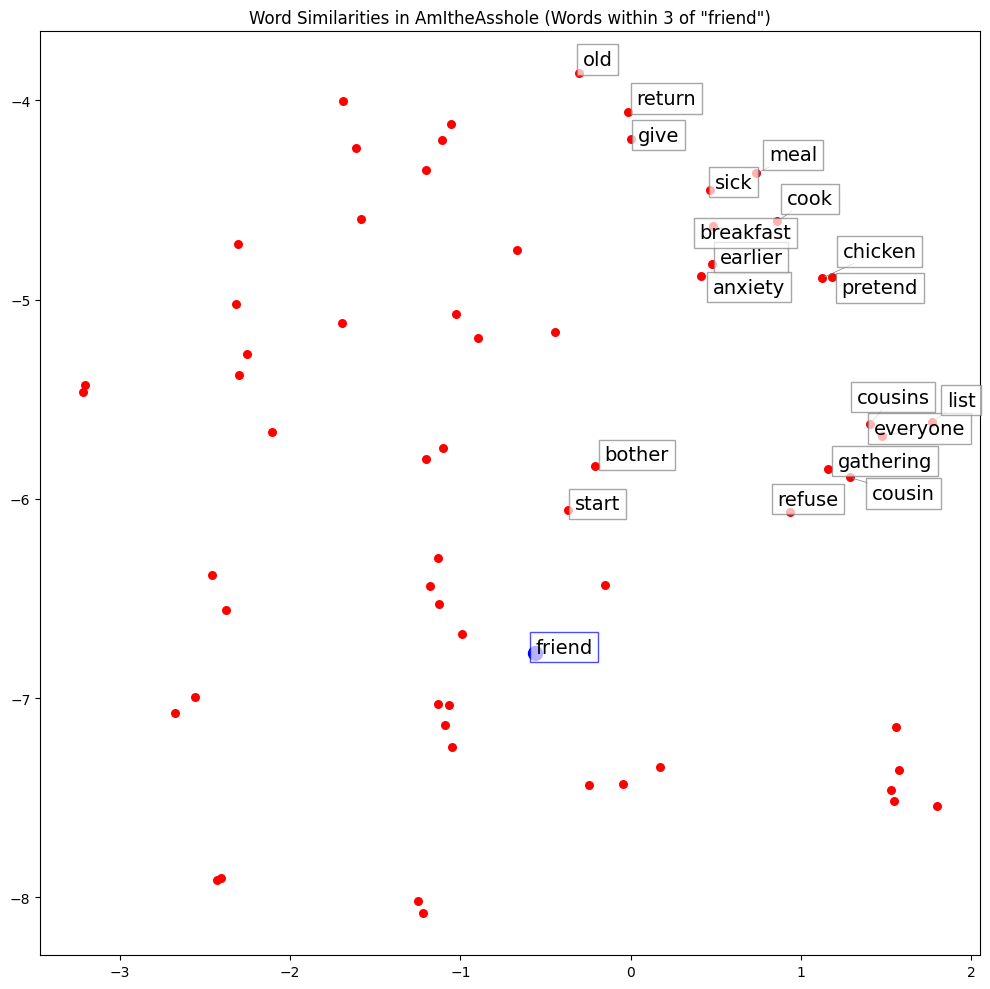

In [ ]:
word_distance_reveal(results['AmItheAsshole']['tfidf_results']['tfidf_matrix'], 
                                        results['AmItheAsshole']['tfidf_results']['feature_names'], 'friend', distance=3,  
                                        xlim = (-0.4, 2), ylim=(-6.4, -3),
                                        title = "AmItheAsshole")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in AmItheAsshole (Words within 3 of "friend")'}>)

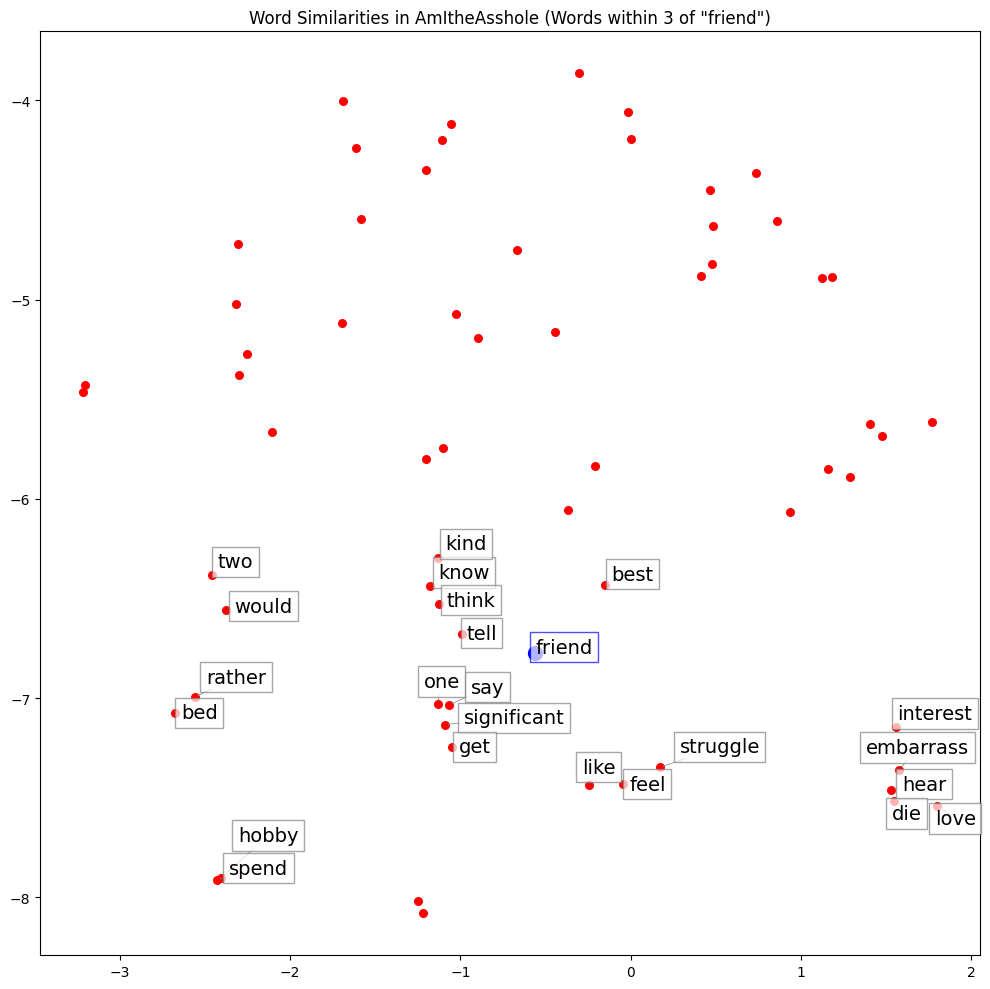

In [175]:
word_distance_reveal(results['AmItheAsshole']['tfidf_results']['tfidf_matrix'], 
                                        results['AmItheAsshole']['tfidf_results']['feature_names'], 'friend', distance=3,  
                                        xlim = (-5, 5), ylim=(-8, -6.2),
                                        title = "AmItheAsshole")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in tifu (Words within 3 of "friend")'}>)

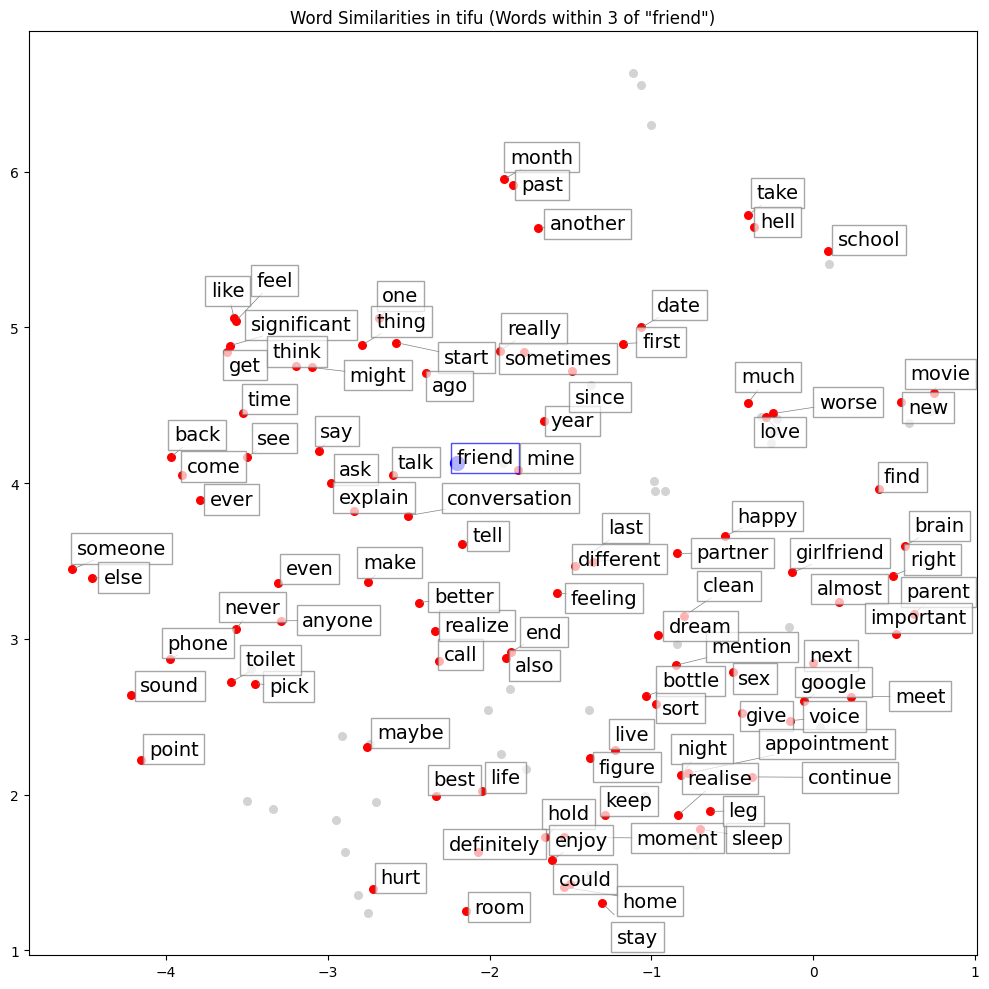

In [178]:
plot_word_distance(results['tifu']['tfidf_results']['tfidf_matrix'], results['tifu']['tfidf_results']['feature_names'], word='friend', distance=3, n_highlight=100, title='tifu')

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in tifu (Words within 3 of "friend")'}>)

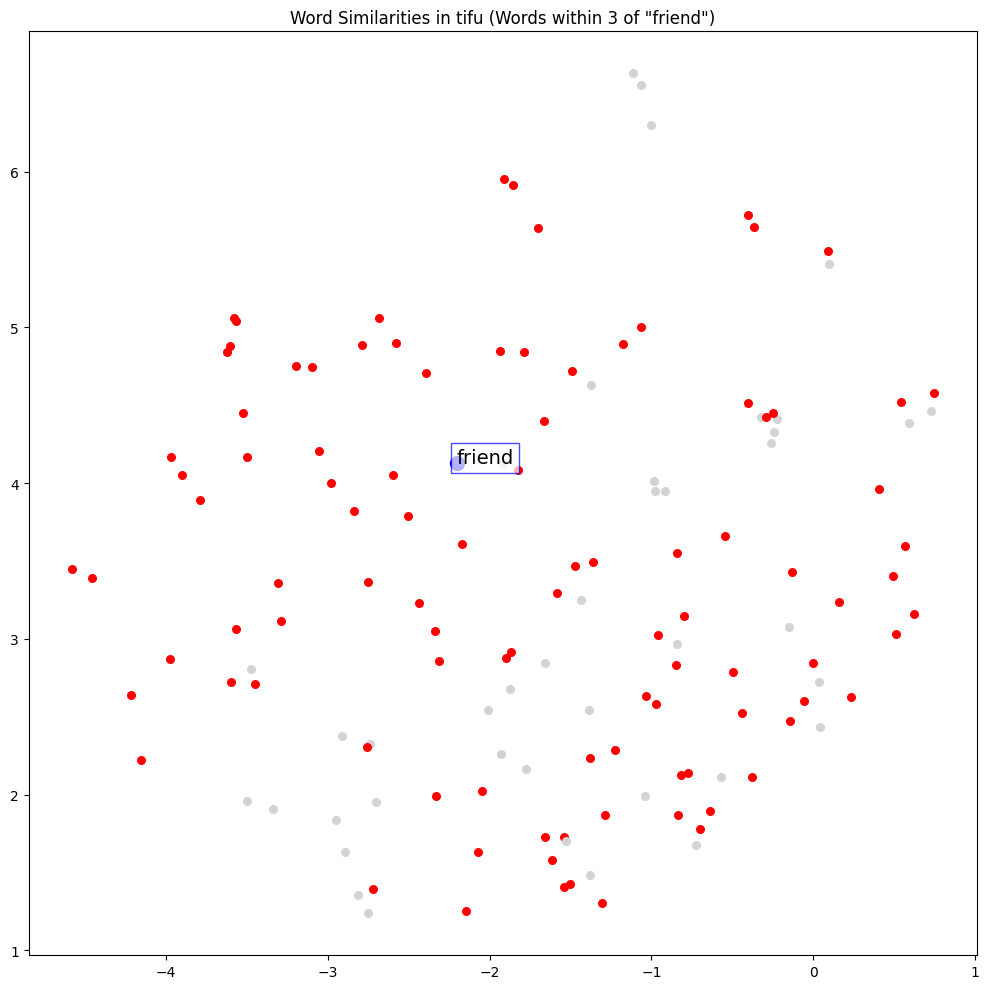

In [179]:
word_distance_reveal(results['tifu']['tfidf_results']['tfidf_matrix'], 
                                        results['tifu']['tfidf_results']['feature_names'], 'friend', distance=3,  
                                        xlim = (50, 51), ylim=(50, 51),
                                        title = "tifu")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in tifu (Words within 3 of "friend")'}>)

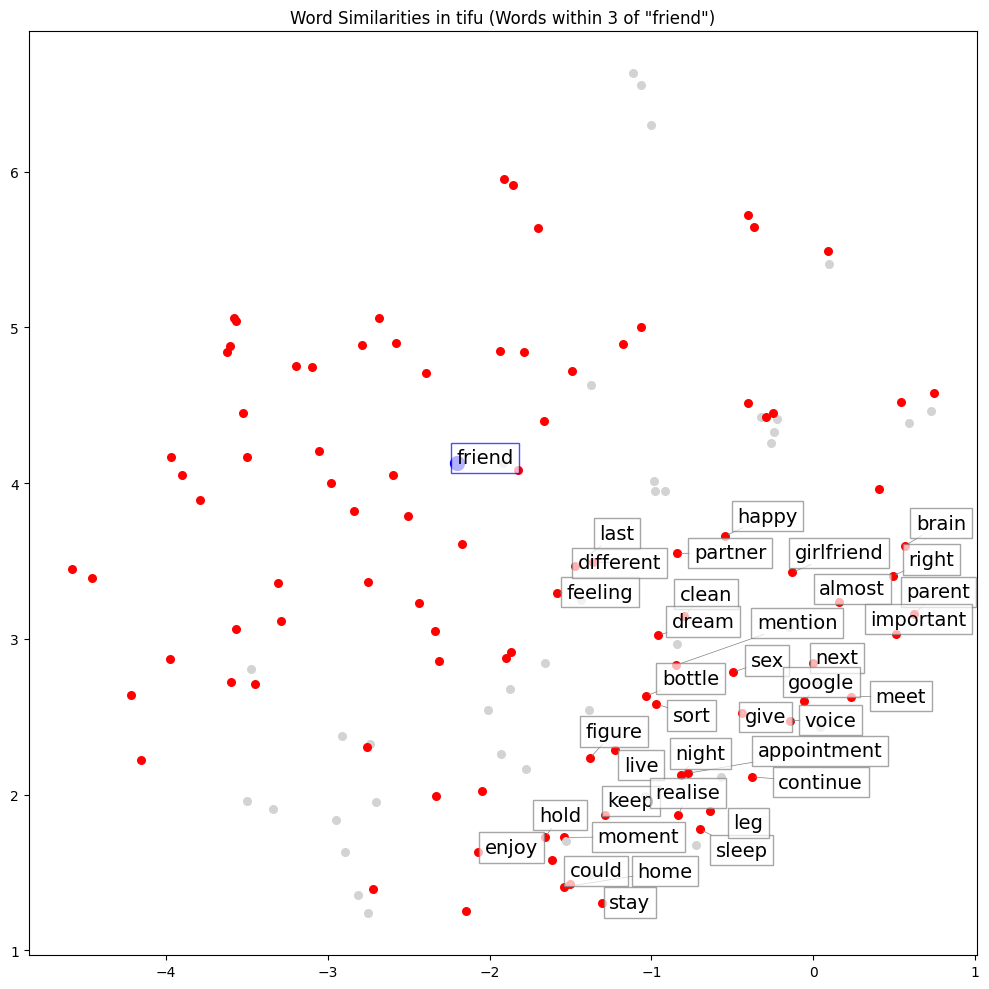

In [181]:
word_distance_reveal(results['tifu']['tfidf_results']['tfidf_matrix'], 
                                        results['tifu']['tfidf_results']['feature_names'], 'friend', distance=3,  
                                        xlim = (-1.8, 51), ylim=(-51, 3.7),
                                        title = "tifu")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in tifu (Words within 3 of "friend")'}>)

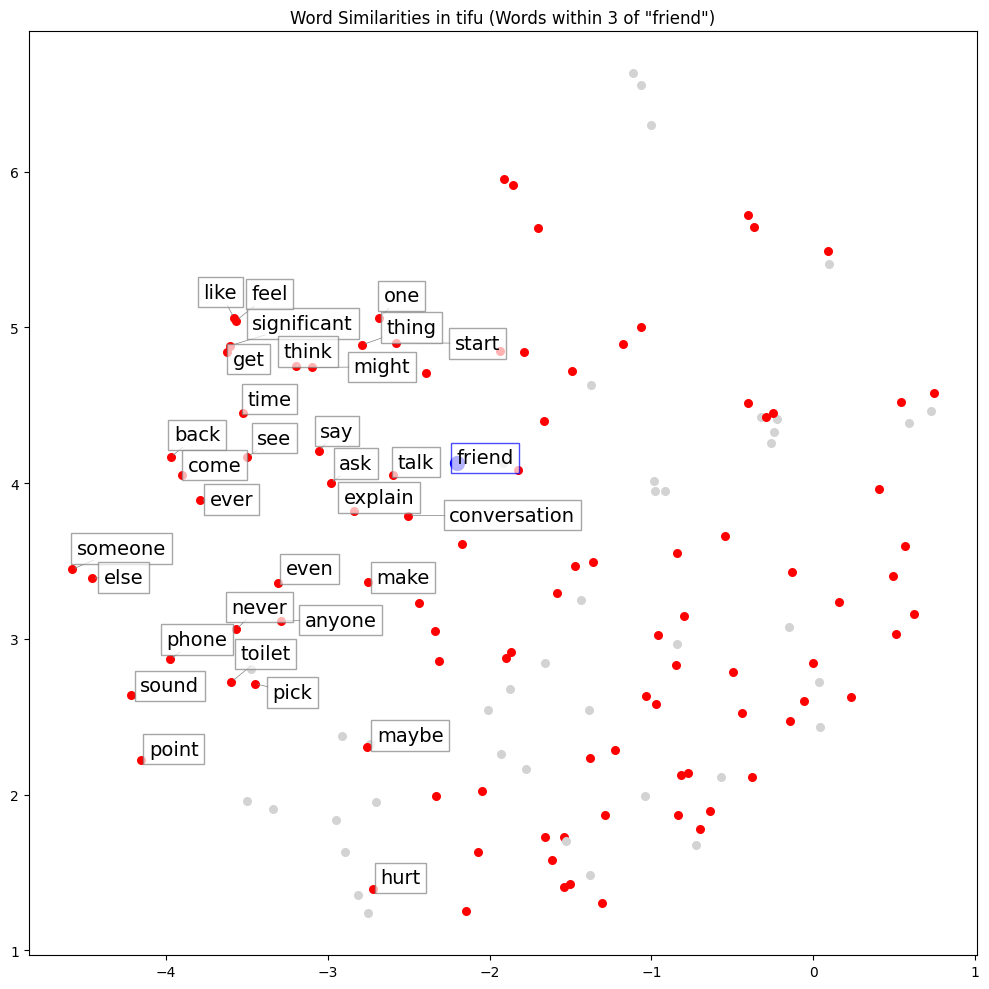

In [182]:
word_distance_reveal(results['tifu']['tfidf_results']['tfidf_matrix'], 
                                        results['tifu']['tfidf_results']['feature_names'], 'friend', distance=3,  
                                        xlim = (-51, -2.5), ylim=(-51, 51),
                                        title = "tifu")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in tifu (Words within 3 of "friend")'}>)

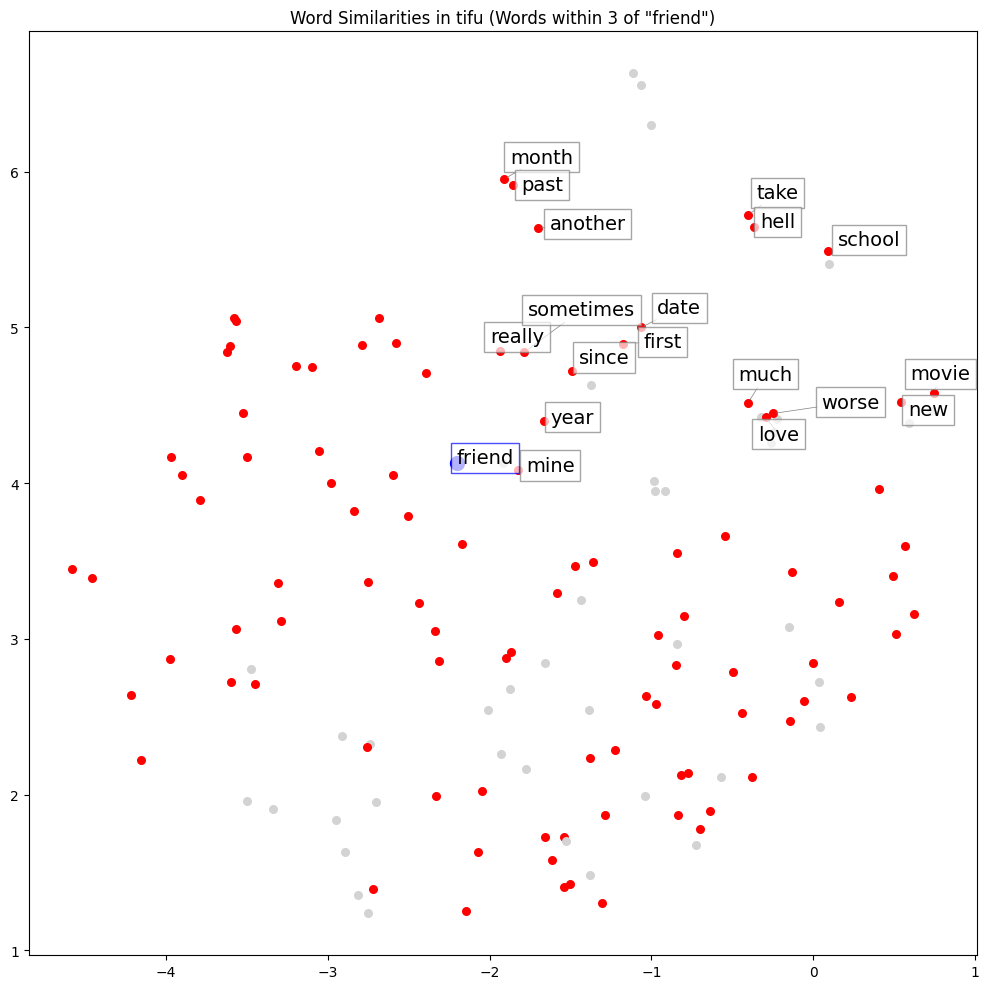

In [184]:
word_distance_reveal(results['tifu']['tfidf_results']['tfidf_matrix'], 
                                        results['tifu']['tfidf_results']['feature_names'], 'friend', distance=3,  
                                        xlim = (-2, 50), ylim=(4, 51),
                                        title = "tifu")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in confessions (Words within 3 of "friend")'}>)

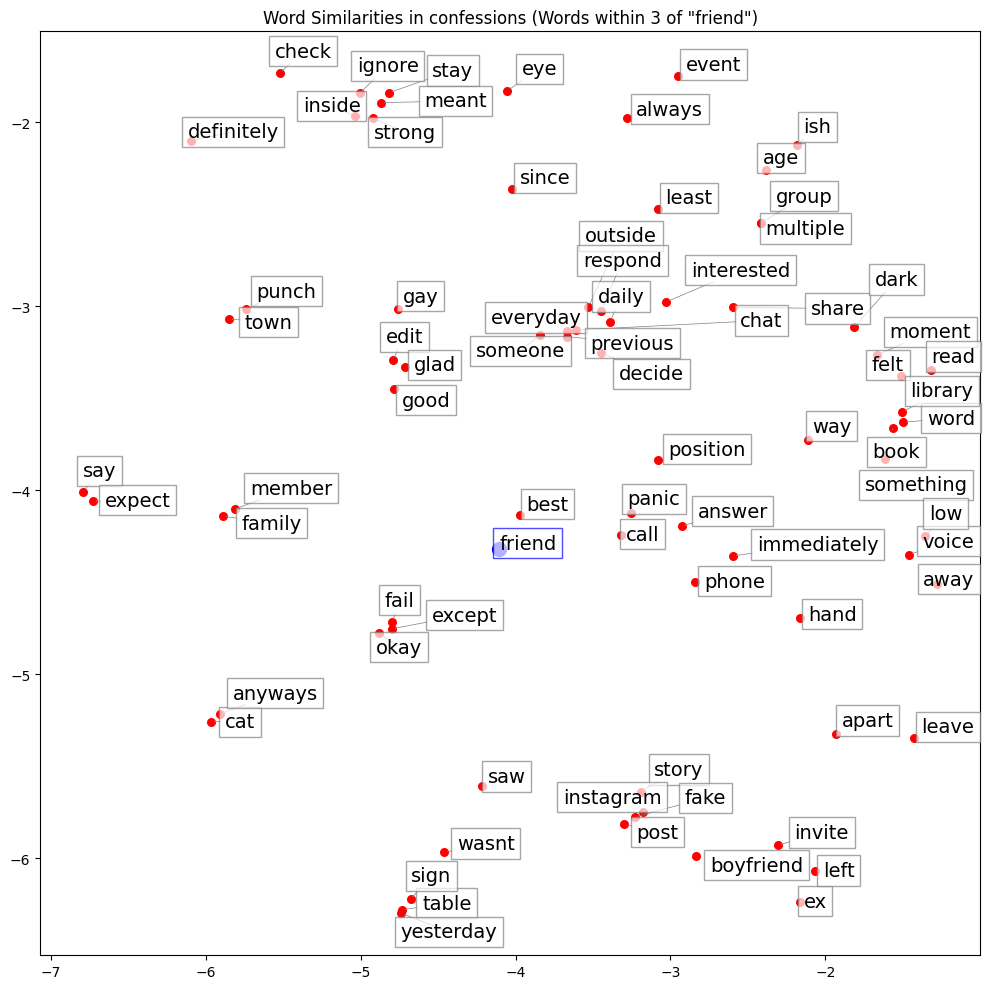

In [183]:
plot_word_distance(results['confessions']['tfidf_results']['tfidf_matrix'], results['confessions']['tfidf_results']['feature_names'], word='friend', distance=3, n_highlight=100, title='confessions')

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in confessions (Words within 3 of "friend")'}>)

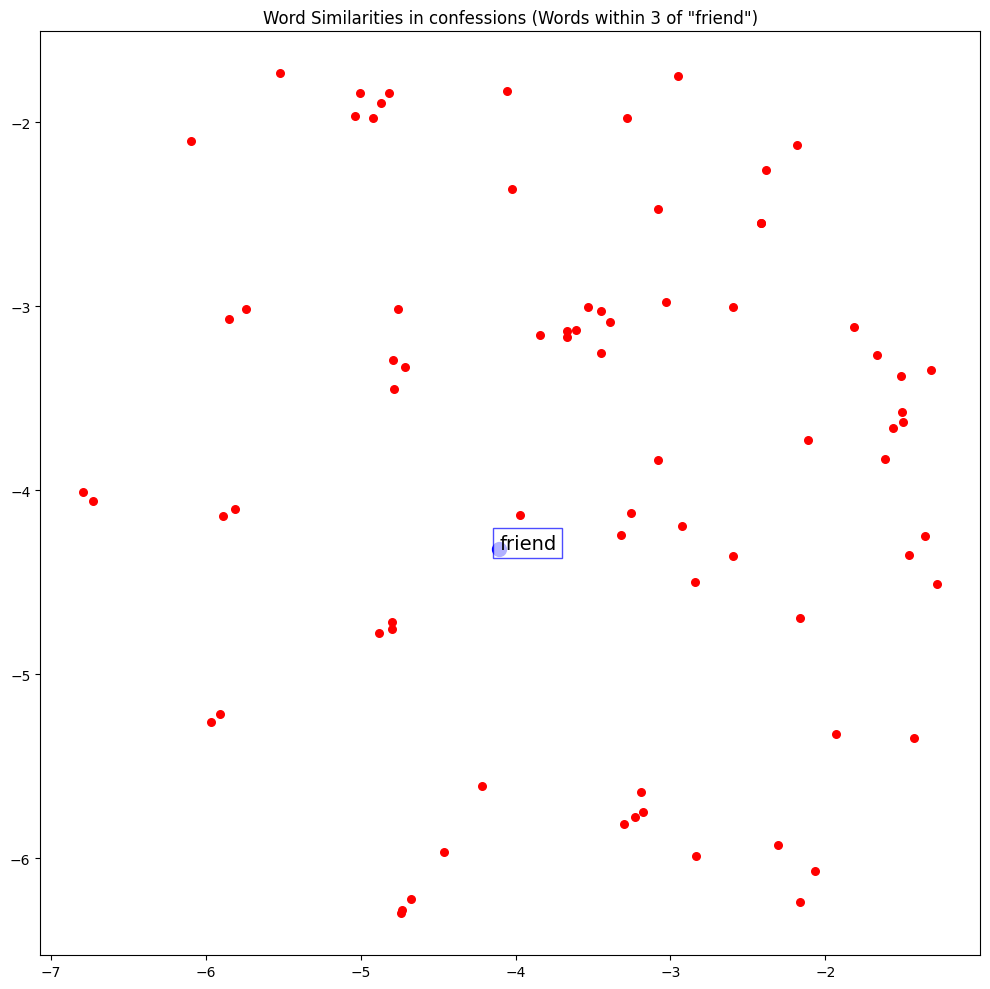

In [187]:
word_distance_reveal(results['confessions']['tfidf_results']['tfidf_matrix'], 
                                        results['confessions']['tfidf_results']['feature_names'], 'friend', distance=3,  
                                        xlim = (50, 51), ylim=(50, 51),
                                        title = "confessions")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in confessions (Words within 3 of "friend")'}>)

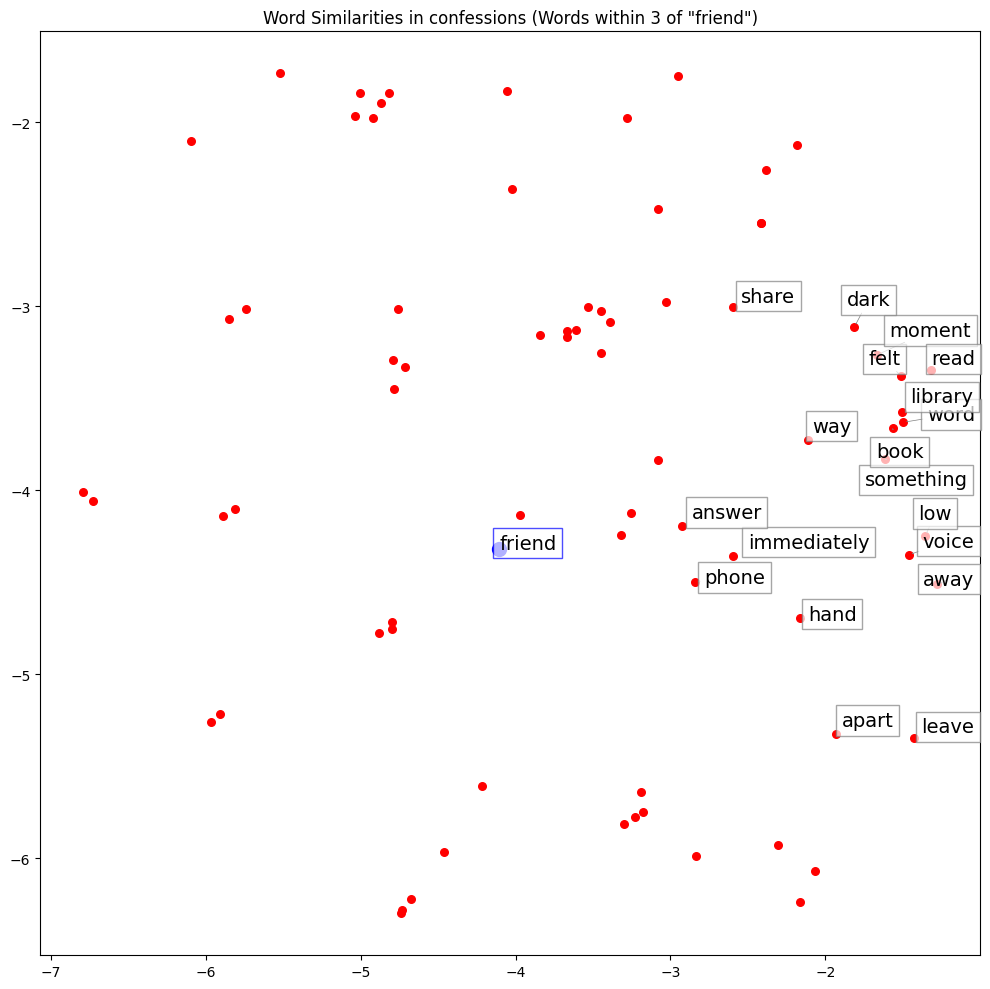

In [188]:
word_distance_reveal(results['confessions']['tfidf_results']['tfidf_matrix'], 
                                        results['confessions']['tfidf_results']['feature_names'], 'friend', distance=3,  
                                        xlim = (-3, 51), ylim=(-5.5, -3),
                                        title = "confessions")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in confessions (Words within 3 of "friend")'}>)

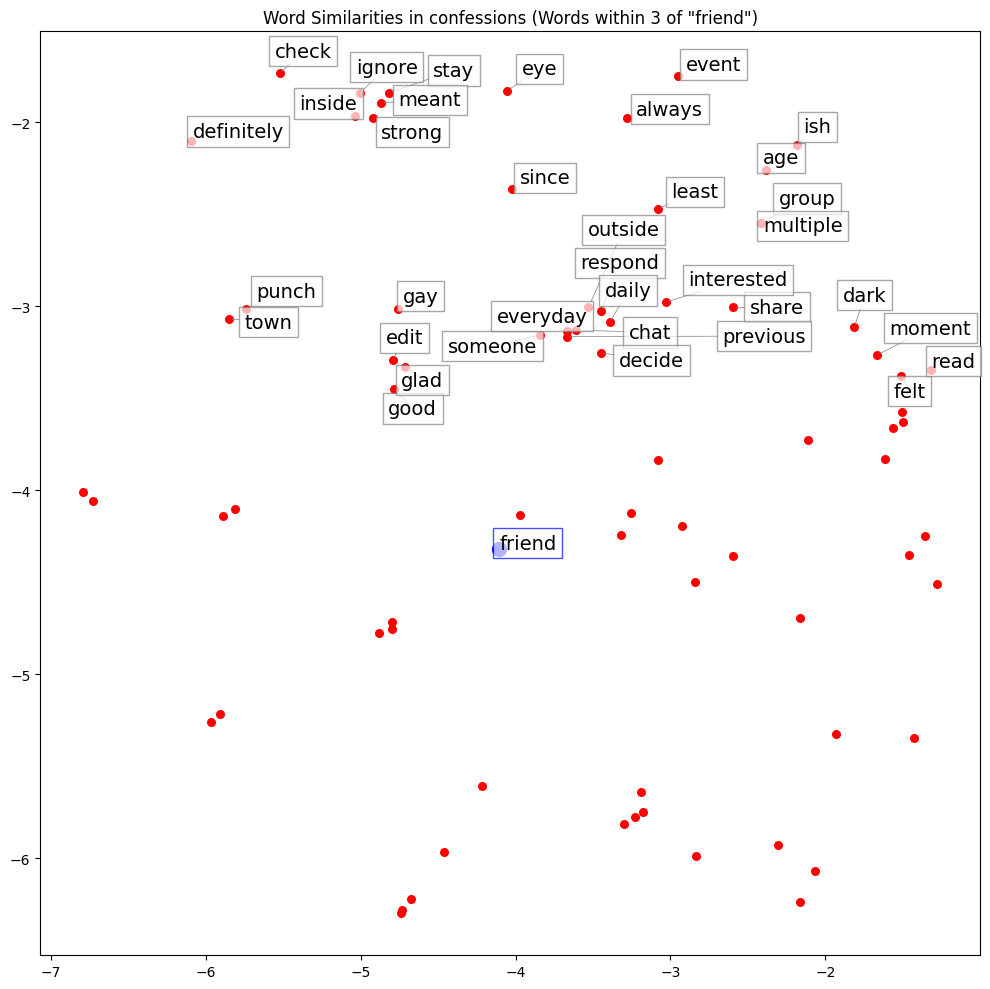

In [189]:
word_distance_reveal(results['confessions']['tfidf_results']['tfidf_matrix'], 
                                        results['confessions']['tfidf_results']['feature_names'], 'friend', distance=3,  
                                        xlim = (-10, 0), ylim=(-3.5, 10),
                                        title = "confessions")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in confessions (Words within 3 of "friend")'}>)

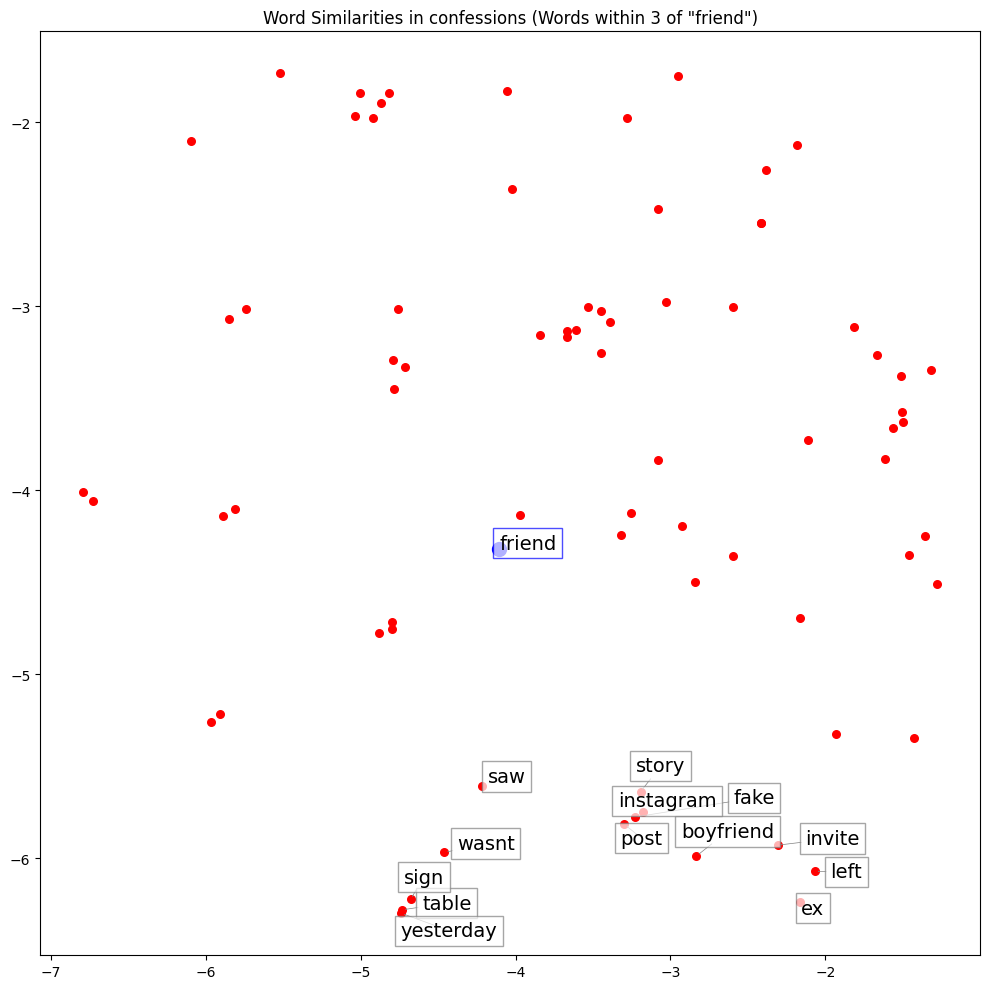

In [190]:
word_distance_reveal(results['confessions']['tfidf_results']['tfidf_matrix'], 
                                        results['confessions']['tfidf_results']['feature_names'], 'friend', distance=3,  
                                        xlim = (-10, 0), ylim=(-10, -5.5),
                                        title = "confessions")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in confessions (Words within 3 of "friend")'}>)

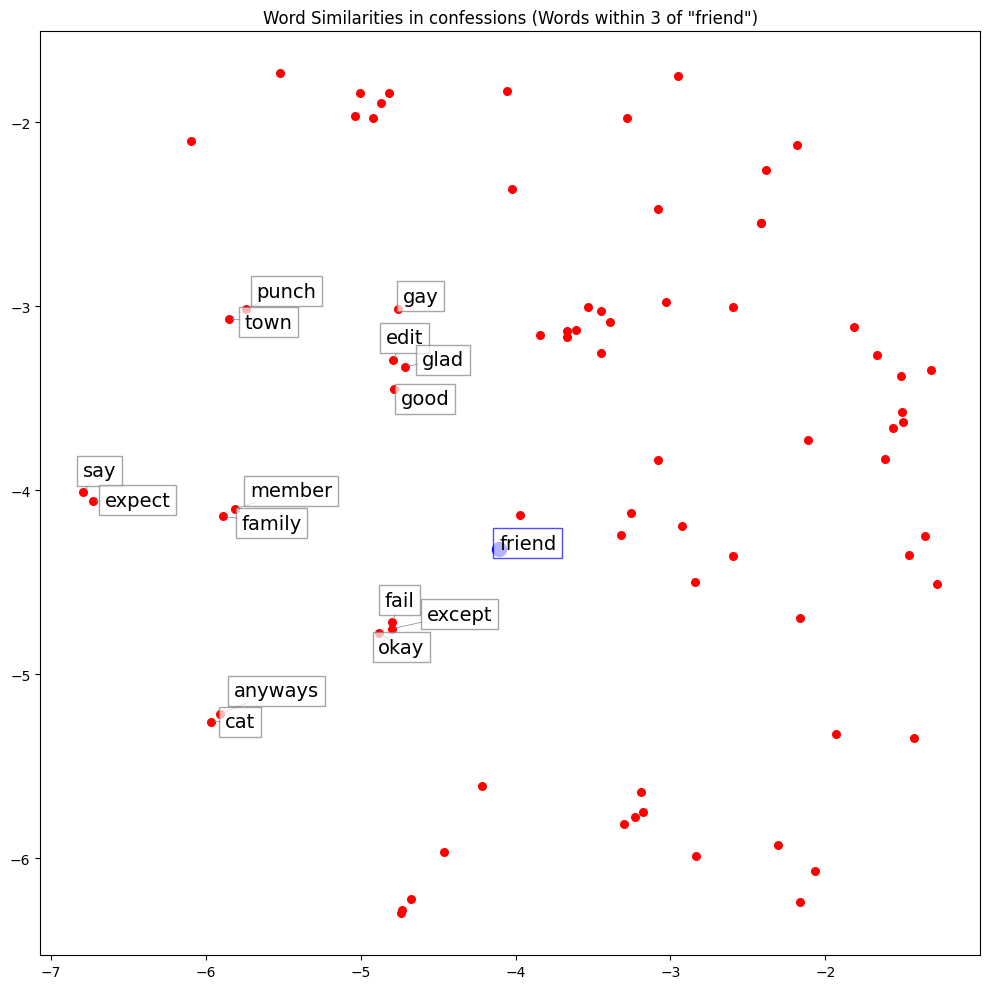

In [194]:
word_distance_reveal(results['confessions']['tfidf_results']['tfidf_matrix'], 
                                        results['confessions']['tfidf_results']['feature_names'], 'friend', distance=3,  
                                        xlim = (-10, -4.6), ylim=(-5.4, -2.7),

                                        title = "confessions")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in confessions (Highlighted Terms)'}>)

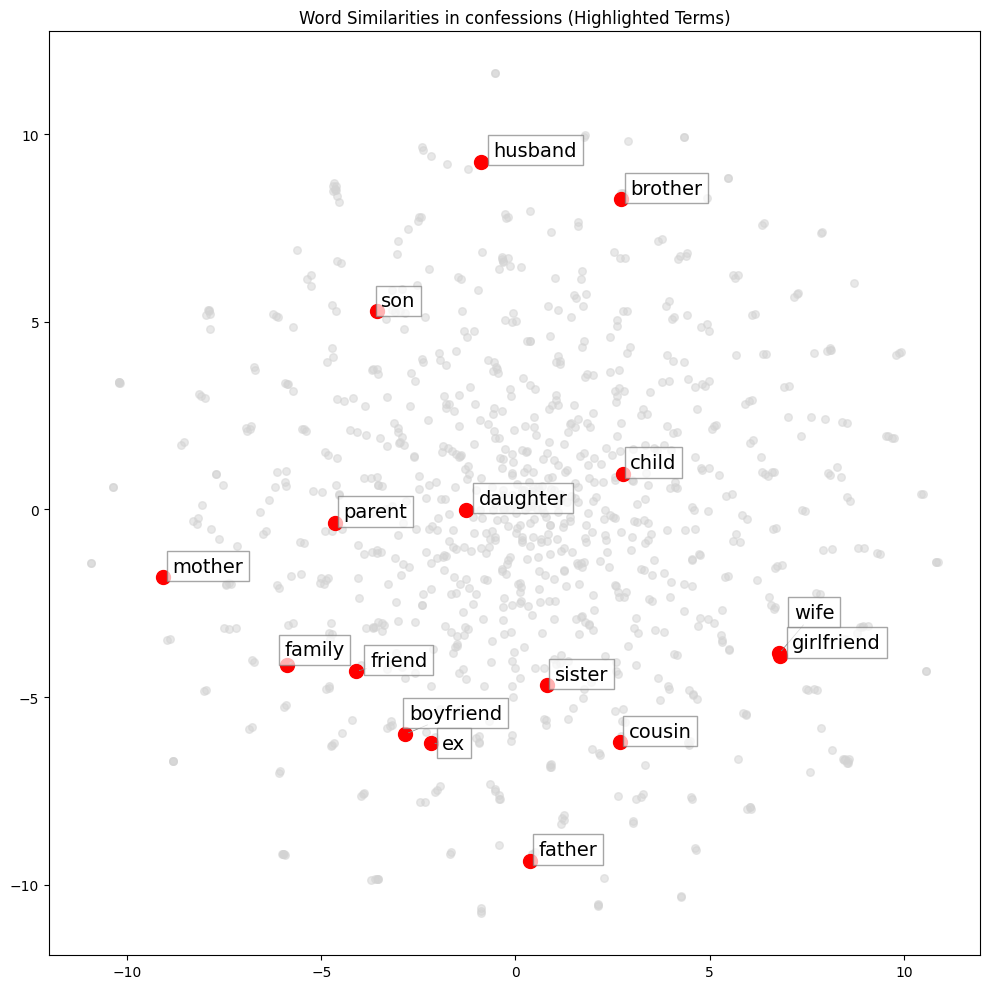

In [208]:
plot_specific_words(results['confessions']['tfidf_results']['tfidf_matrix'], 
                                        results['confessions']['tfidf_results']['feature_names'], 
                                        ['boyfriend', 'brother', 'child', 'cousin', 'daughter', 'ex', 'family', 'father', 'friend', 'girlfriend', 'husband',
                                         'mother', 'parent', 'sister', 'son', 'wife'],
                                        title = "confessions")

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in AmItheAsshole (Highlighted Terms)'}>)

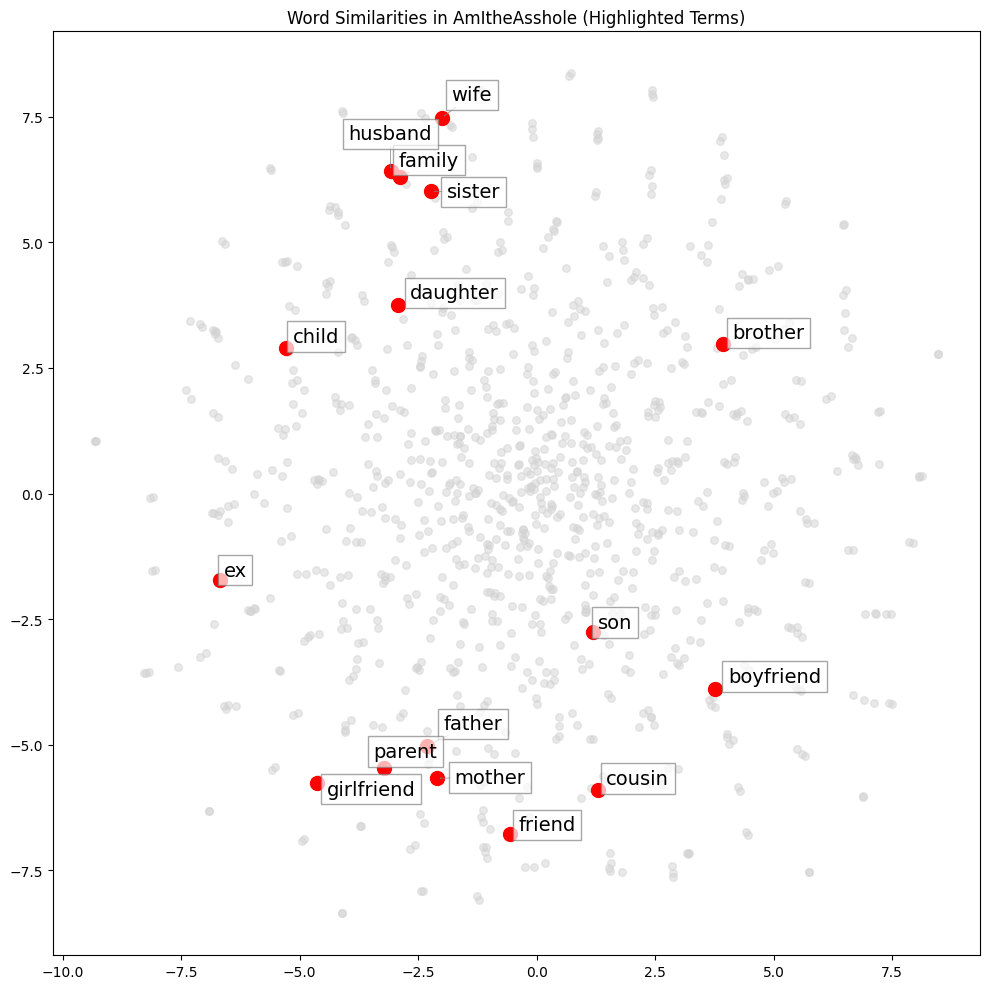

In [209]:
subreddit = "AmItheAsshole"
plot_specific_words(results[subreddit]['tfidf_results']['tfidf_matrix'], 
                                        results[subreddit]['tfidf_results']['feature_names'], 
                                        ['boyfriend', 'brother', 'child', 'cousin', 'daughter', 'ex', 'family', 'father', 'friend', 'girlfriend', 'husband',
                                         'mother', 'parent', 'sister', 'son', 'wife'],
                                        title = subreddit)

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in tifu (Highlighted Terms)'}>)

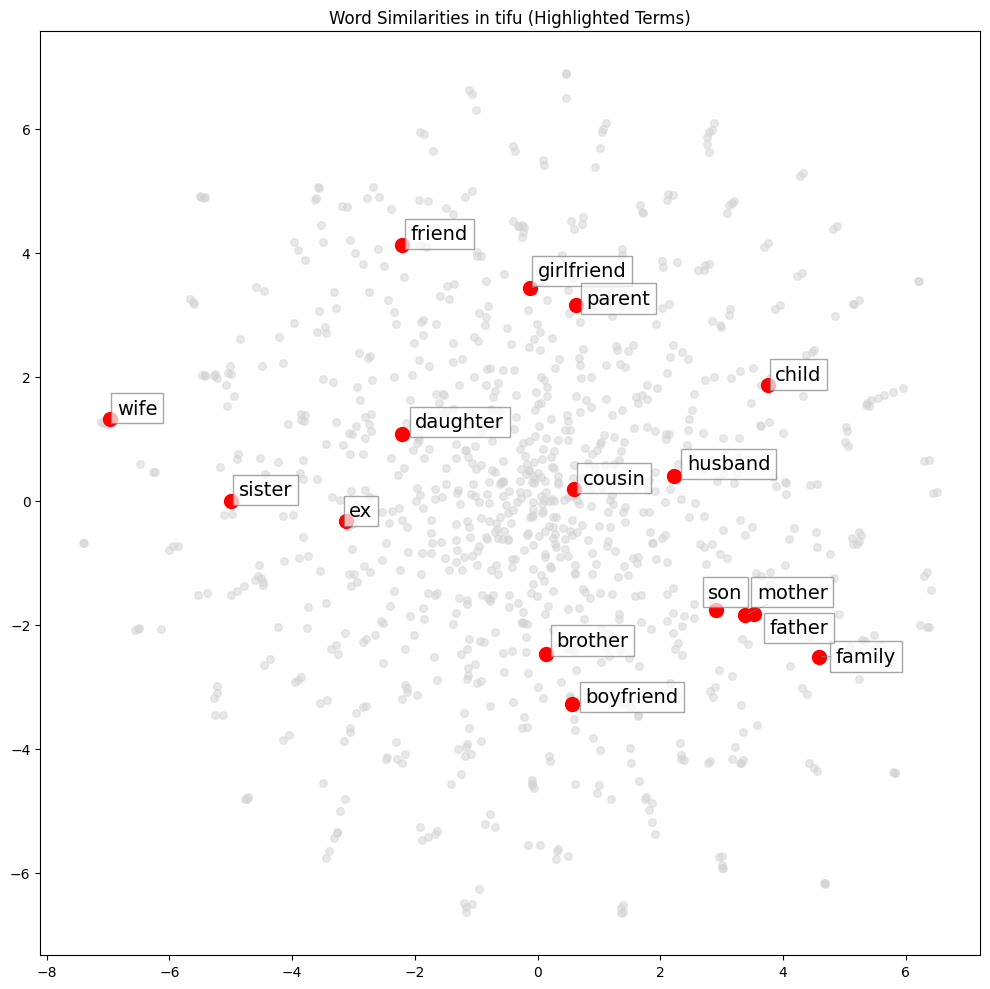

In [210]:
subreddit = "tifu"
plot_specific_words(results[subreddit]['tfidf_results']['tfidf_matrix'], 
                                        results[subreddit]['tfidf_results']['feature_names'], 
                                        ['boyfriend', 'brother', 'child', 'cousin', 'daughter', 'ex', 'family', 'father', 'friend', 'girlfriend', 'husband',
                                         'mother', 'parent', 'sister', 'son', 'wife'],
                                        title = subreddit)